# Data Analysis

In [1]:
import json

import h5py
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import analysis

[16:57:40] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=331946;file:///home/andreas/.virtualenvs/lbm-jax/lib/python3.10/site-packages/openpnm/utils/_workspace.py\_workspace.py]8;;\:]8;id=472755;file:///home/andreas/.virtualenvs/lbm-jax/lib/python3.10/site-packages/openpnm/utils/_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

# Function and Constant Definitions

In [2]:
LATTICE_VELOCITIES_X = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1, ])
LATTICE_VELOCITIES_Y = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1, ])
LATTICE_VELOCITIES = jnp.array([
    LATTICE_VELOCITIES_X,
    LATTICE_VELOCITIES_Y, ]
)

In [3]:
def get_macroscopic_velocities(discrete_velocities):
    density = jnp.sum(discrete_velocities, axis=-1)
    macroscopic_velocities = jnp.einsum(
        "NMQ,dQ->NMd",
        discrete_velocities,
        LATTICE_VELOCITIES
    ) / density[..., jnp.newaxis]
    return macroscopic_velocities


def calculate_porosity(mask):
    x, y = mask.shape
    return ((x * y) - jnp.sum(mask)) / (x * y)


def pressure_drop(file_path):
    f = open(file_path)
    forces = json.load(f)
    total = [0, 0]
    for index, forces in forces["forces1_1"].items():
        x = float(forces["x"])
        y = float(forces["y"])
        total[0] += x
        total[1] += y
    return np.sqrt(total[0] ** 2 + total[1] ** 2)


def pressure(discrete_velocities):
    density = jnp.sum(discrete_velocities, axis=-1)
    p1 = jnp.mean(density[1, 40:400]) / 3
    p2 = jnp.mean(density[-2, 40:400]) / 3
    return p2 - p1


def pressure_calc(discrete_velocities, mask):
    # Calculate the density
    density = jnp.sum(discrete_velocities, axis=-1)

    # Speed of sound squared, cs^2 (for D2Q9, cs^2 = 1/3)
    cs_square = 1 / 3

    # Calculate the pressure using the equation of state: P = rho * cs^2
    pressure = density * cs_square

    # Apply the mask (assuming False in mask means valid values to include)
    masked_pressure = jnp.where(mask, jnp.nan, pressure)

    # Calculate mean pressure for each column, excluding masked points
    mean_pressure_per_column = jnp.nanmean(masked_pressure, axis=0)
    return mean_pressure_per_column


def reynolds(vel, porosity):
    return porosity * vel * 20 / 0.01


def permeability(dP, vel):
    return vel * 0.01 * 400 / dP


def teoric_permeability(porosity):
    return 0.01515 * np.pi * (porosity ** 5.1 / (1 - porosity))


def rolling_window(a: jnp.ndarray, window: int):
    idx = jnp.arange(len(a) - window + 1)[:, None] + jnp.arange(window)[None, :]
    return a[idx]


def rolling_mean(a, window):
    return jnp.mean(rolling_window(a, window), axis=-1)


def rolling_window_2d(a, window):
    # Adding padding to handle the edges
    pad_width = ((window // 2, window // 2), (window // 2, window // 2))
    a_padded = np.pad(a, pad_width, mode='reflect')

    # Create the 2D windowed view of the array
    shape = (a.shape[0] - window + 1, a.shape[1] - window + 1, window, window)
    strides = a_padded.strides * 2
    return np.lib.stride_tricks.as_strided(a_padded, shape=shape, strides=strides)


def rolling_mean_2d(a, window):
    return jnp.mean(rolling_window_2d(a, window), axis=(-2, -1))


def plot_mean_vel_x(macroscopic_velocities):
    mean_x_velocity = jnp.mean(macroscopic_velocities[:, :, 0], axis=0)
    window_size = 60
    rolling_mean_x_velocity = rolling_mean(mean_x_velocity, window_size)

    first_derivative = jnp.gradient(mean_x_velocity)
    second_derivative = jnp.gradient(first_derivative)
    max_first_derivative_index = jnp.argmax(first_derivative)
    max_first_derivative_value = first_derivative[max_first_derivative_index]
    max_first_derivative_y_coord = max_first_derivative_index

    # Plotting
    fig1 = plt.figure(figsize=(10, 10))
    plt.plot(mean_x_velocity, jnp.arange(mean_x_velocity.shape[0]))
    plt.xlabel(r'$\bar{u}_{x}$')
    plt.ylabel('Altura (Y)')
    plt.title(r'$\bar{u}_{x}$ vs Altura')
    plt.show()

    fig2 = plt.figure(figsize=(10, 10))
    print(second_derivative[max_first_derivative_y_coord])
    plt.plot(first_derivative, jnp.arange(first_derivative.shape[0]), label='Primeira derivada')
    plt.plot(second_derivative, jnp.arange(second_derivative.shape[0]), label='Segunda derivada', linestyle="--")
    plt.scatter(max_first_derivative_value, max_first_derivative_y_coord, color='red', label='Ponto máximo')
    plt.annotate(f'$Y_{{max}}$= {max_first_derivative_y_coord}',
                 (max_first_derivative_value, max_first_derivative_y_coord),
                 textcoords="offset points", xytext=(10, 10), ha='center', color='red')
    plt.xlabel(r'$\bar{u}_{x}$')
    plt.ylabel('Altura (Y)')
    plt.title(r'$\bar{u}_{x}$ vs Altura')
    plt.legend()
    plt.show()

    fig3 = plt.figure(figsize=(10, 10))
    plt.plot(rolling_mean_x_velocity, jnp.arange(rolling_mean_x_velocity.shape[0]))
    plt.xlabel(r'$\bar{u}_{mov,x}$')
    plt.ylabel('Altura (Y)')
    plt.title(rf'$\bar{{u}}_{{mov,x}}$vs Altura (Janela: {window_size})')
    plt.show()

    first_derivative = jnp.gradient(rolling_mean_x_velocity)
    second_derivative = jnp.gradient(first_derivative)
    max_first_derivative_index = jnp.argmax(first_derivative)
    max_first_derivative_value = first_derivative[max_first_derivative_index]
    max_first_derivative_y_coord = max_first_derivative_index

    fig4 = plt.figure(figsize=(10, 10))
    print(second_derivative[max_first_derivative_y_coord])
    plt.plot(first_derivative, jnp.arange(first_derivative.shape[0]), label='Primeira derivada')
    plt.plot(second_derivative, jnp.arange(second_derivative.shape[0]), label='Segunda derivada', linestyle="--")
    plt.scatter(max_first_derivative_value, max_first_derivative_y_coord, color='red', label='Ponto máximo')
    plt.annotate(f'$Y_{{max}}$= {max_first_derivative_y_coord}',
                 (max_first_derivative_value, max_first_derivative_y_coord),
                 textcoords="offset points", xytext=(10, 10), ha='center', color='red')
    plt.xlabel(r'$\bar{u}_{mov,x}$')
    plt.ylabel('Altura (Y)')
    plt.title(rf'$\bar{{u}}_{{mov,x}}$vs Altura (Janela: {window_size})')
    plt.legend()
    plt.show()

    return [fig1, fig2, fig3, fig4]


def plot_velocity_field(velocities, mask, x_range=None, y_range=None, apply_sampling=False,
                        sampling_rate=5, scale=0.01):
    """
    Plot the macroscopic velocity field with options for masking, sampling, and focusing on a specific region.
    Returns the figure object for further manipulation or saving.

    Parameters:
    - velocities: The macroscopic velocities array.
    - mask: The boolean mask array.
    - x_range: The range of x indices to focus on (tuple of start and end index, e.g., (100, 300)).
    - y_range: The range of y indices to focus on (tuple of start and end index).
    - apply_sampling: Whether to apply sampling to reduce the number of arrows.
    - sampling_rate: The rate at which to sample the data.
    - scale: Scale factor for the arrows in the quiver plot.
    """

    # Extract velocity components
    vx, vy = velocities[:, :, 0], velocities[:, :, 1]

    # Apply mask
    vx_masked = np.ma.masked_where(mask, vx)
    vy_masked = np.ma.masked_where(mask, vy)

    # Create meshgrid for plotting
    nx, ny = mask.shape
    x, y = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')

    # Adjust for specified region
    if x_range and y_range:
        x = x[x_range[0]:x_range[1], y_range[0]:y_range[1]]
        y = y[x_range[0]:x_range[1], y_range[0]:y_range[1]]
        vx_masked = vx_masked[x_range[0]:x_range[1], y_range[0]:y_range[1]]
        vy_masked = vy_masked[x_range[0]:x_range[1], y_range[0]:y_range[1]]

    # Apply sampling if needed
    if apply_sampling:
        x = x[::sampling_rate, ::sampling_rate]
        y = y[::sampling_rate, ::sampling_rate]
        vx_masked = vx_masked[::sampling_rate, ::sampling_rate]
        vy_masked = vy_masked[::sampling_rate, ::sampling_rate]

    # Calculate magnitude for color coding
    magnitude = np.sqrt(vx_masked ** 2 + vy_masked ** 2)

    # Create the figure
    fig = plt.figure(figsize=(12, 12))
    # Create the quiver plot
    quiver = plt.quiver(x, y, vx_masked, vy_masked, magnitude, angles='xy', scale_units='xy', scale=scale,
                        cmap='viridis', pivot='mid', headwidth=2.5, headlength=4)
    plt.xlabel('X')
    plt.ylabel('Y')
    title = 'Macroscopic Velocity Field'
    if x_range and y_range:
        title += f' (X:{x_range[0]}-{x_range[1]}, Y:{y_range[0]}-{y_range[1]})'
    if apply_sampling:
        title += f' - Sampling Rate {sampling_rate}'
    plt.title(title)
    plt.gca().set_facecolor('white')
    plt.colorbar(quiver, ax=plt.gca(), orientation='vertical', label='Velocity magnitude')

    # Return the figure object
    return fig

# Generate Object Label Matrix and forces Dictionary (Run Once)

In [ ]:
for i in range(5):
    for j in range(3):

        file_name = f'data{i + 1}_{j + 1}.hdf5'
        print(file_name)
        forces_dict, center_positions, labeled_matrix = (analysis.
                                                         calculate_node_forces(file_name))
        with open(f'data/data_dicts{i + 1}_{j + 1}.json', 'w') as file:
            json.dump({f"forces{i + 1}_{j + 1}": forces_dict,
                       f"center_positions{i + 1}_{j + 1}": center_positions},
                      file, indent=4)
        if j == 0:
            np.save(f"data/labeled_matrix{i + 1}_{j + 1}", labeled_matrix)

        fig = analysis.print_forces(forces_dict, center_positions, labeled_matrix)
        nx, ny = np.array(labeled_matrix).shape
        plt.xlim(0, nx)
        plt.ylim(0, ny / 2)
        plt.show(fig)
        fig.savefig(f'data/forces{i + 1}_{j + 1}.png', dpi=300, bbox_inches='tight')

# Generate Graphs    

(400, 800, 9)
(400, 800, 9)


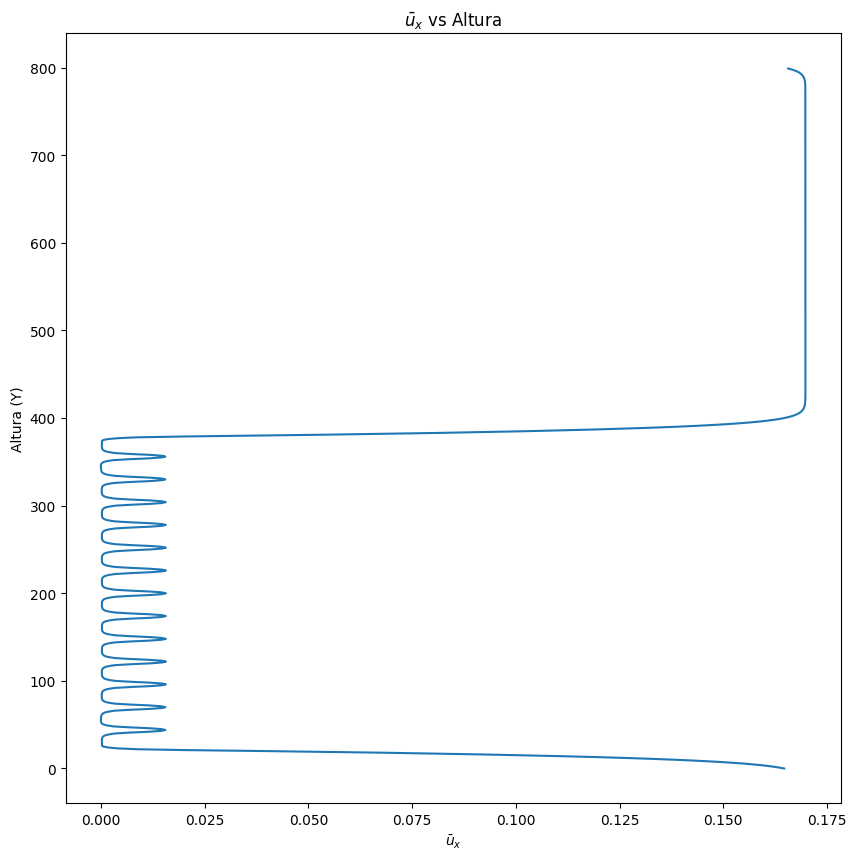

0.00022309266992723287


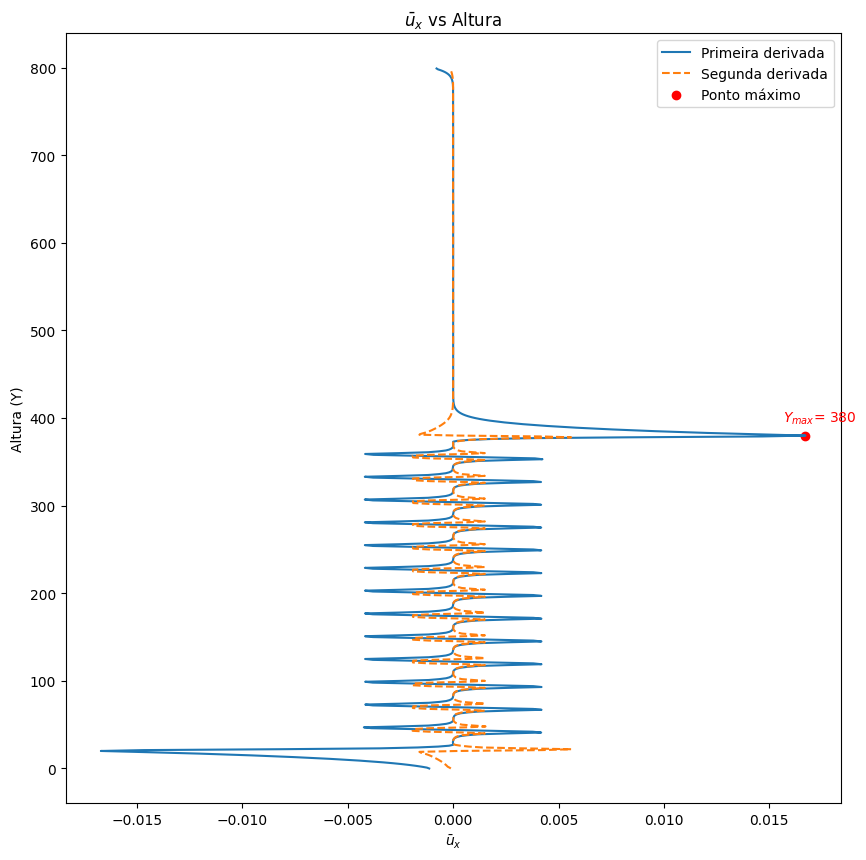

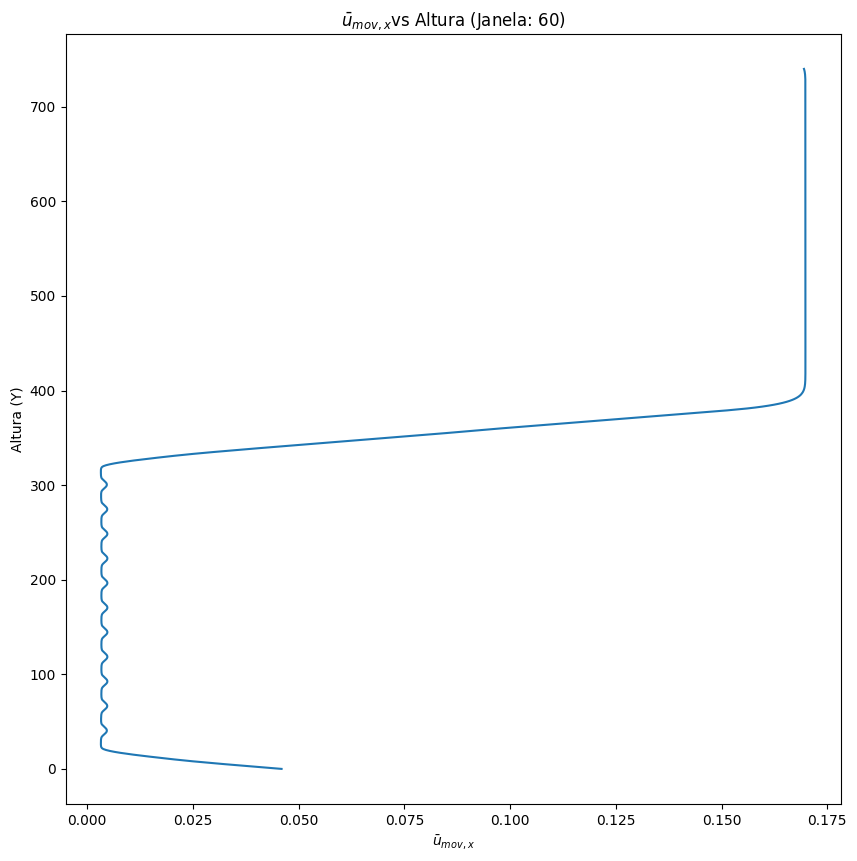

2.626601748600965e-10


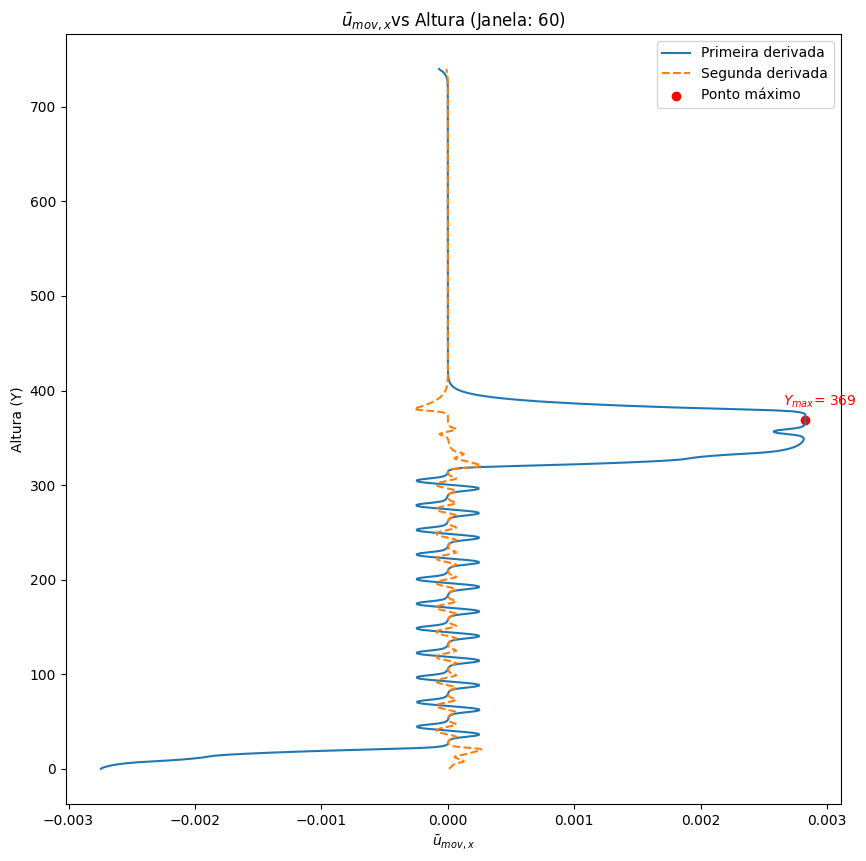

(400, 800, 9)
(400, 800, 9)


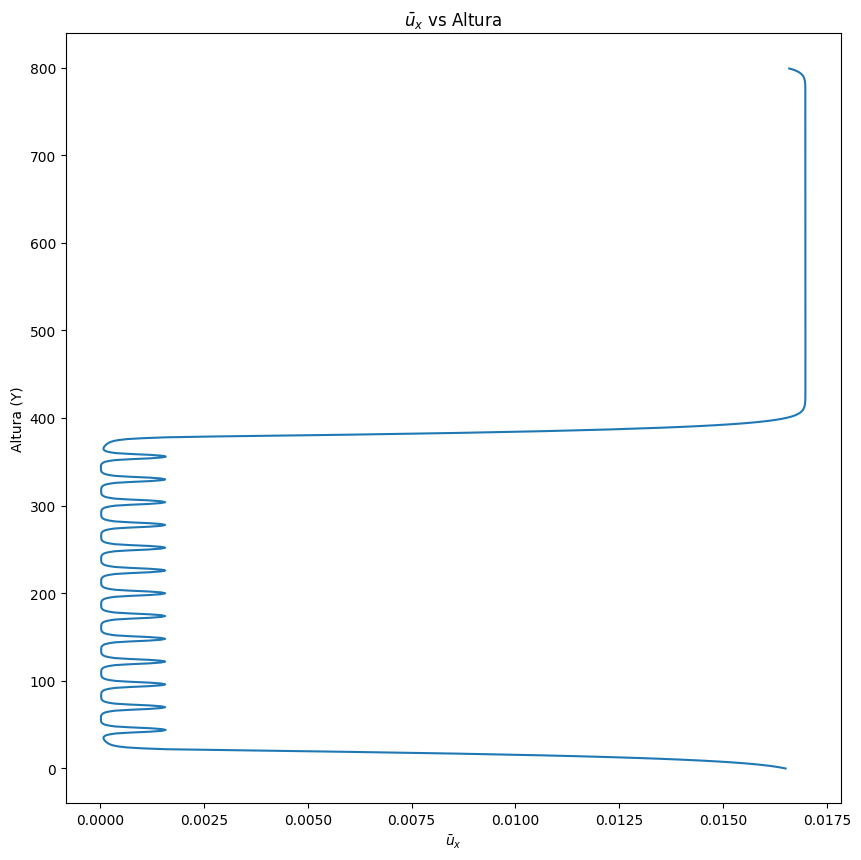

8.477802588248689e-06


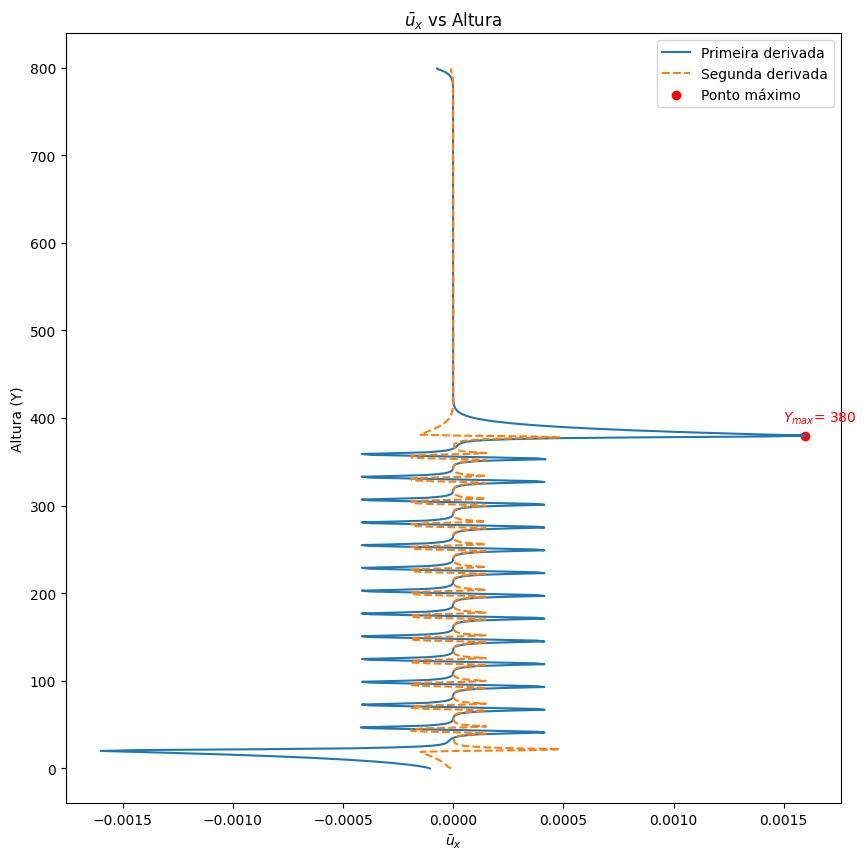

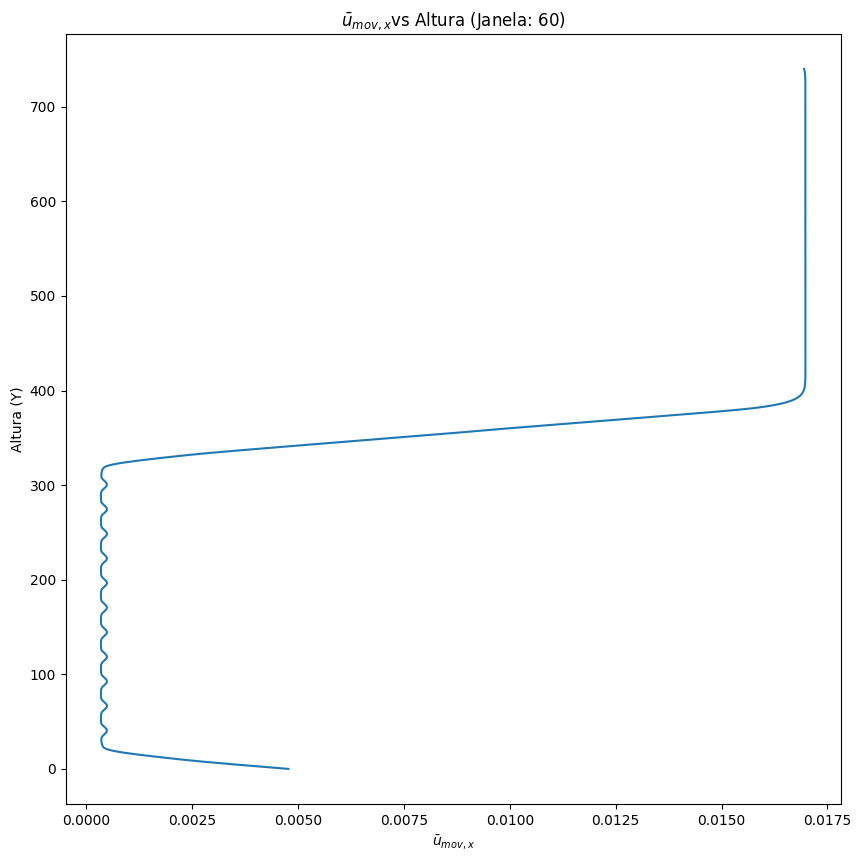

-4.465470929138071e-08


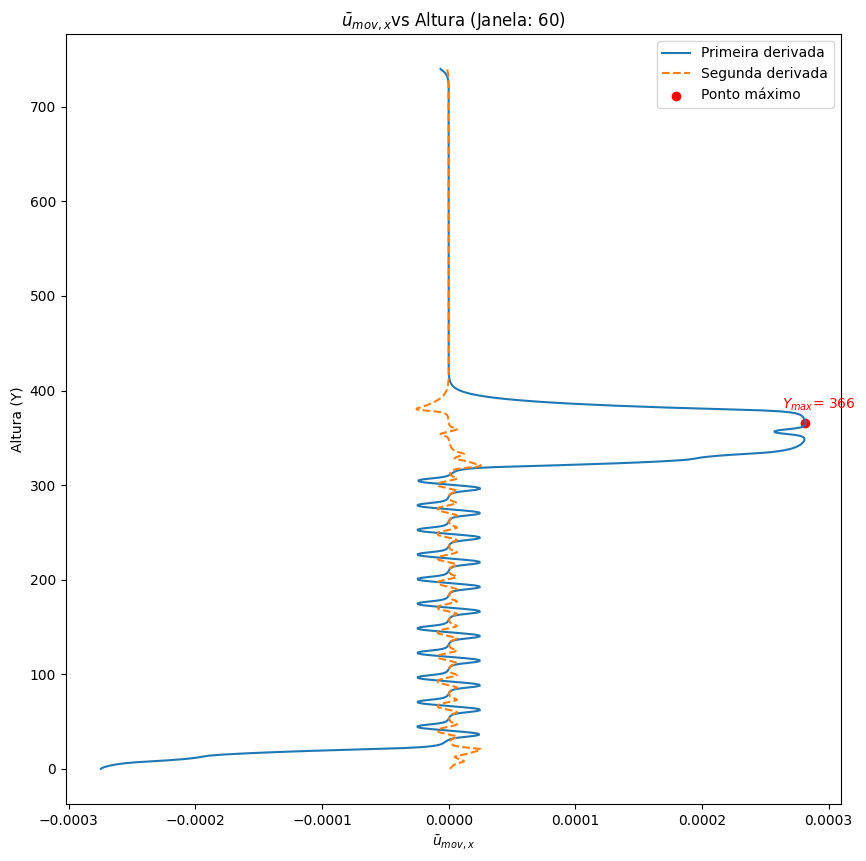

(400, 800, 9)
(400, 800, 9)


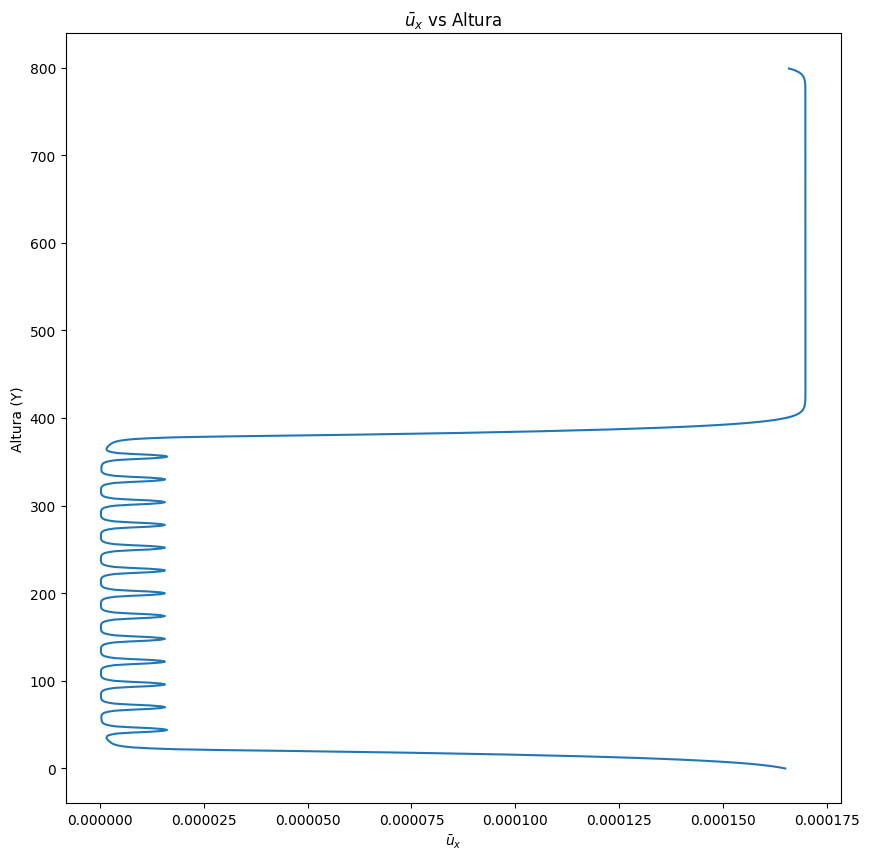

-1.3949521434518107e-09


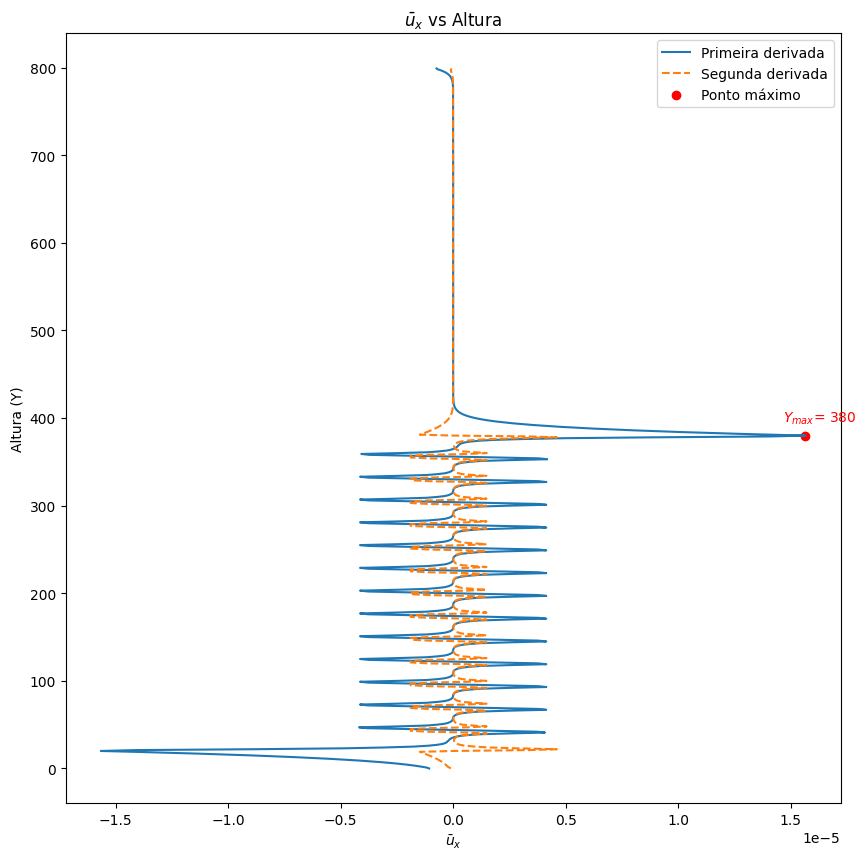

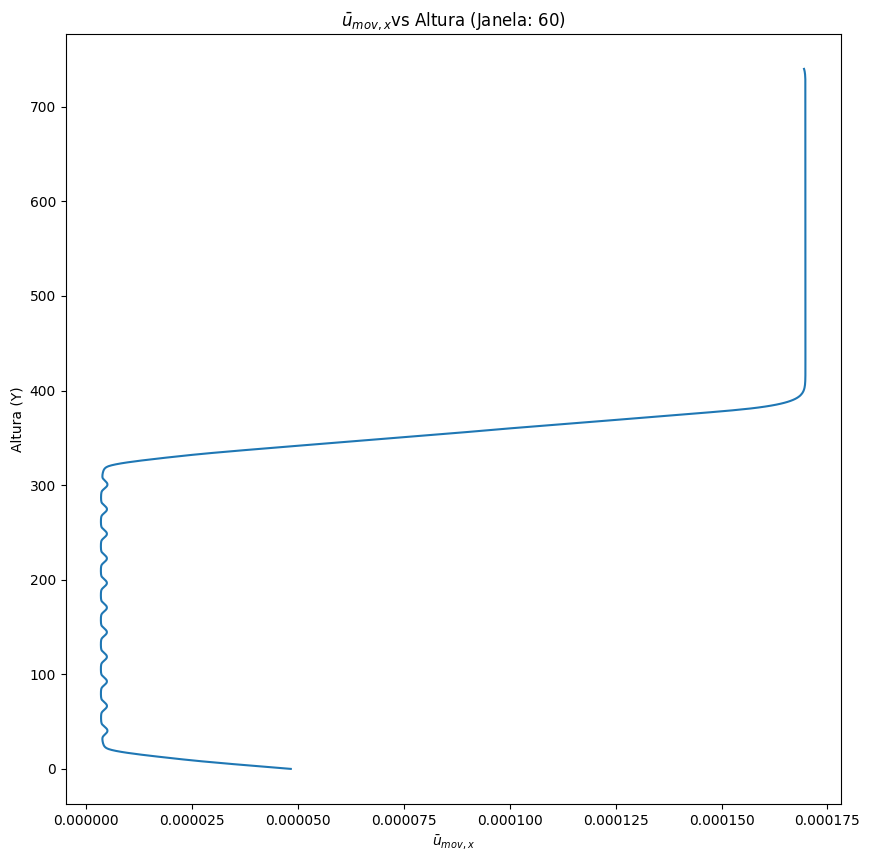

6.507303892476881e-10


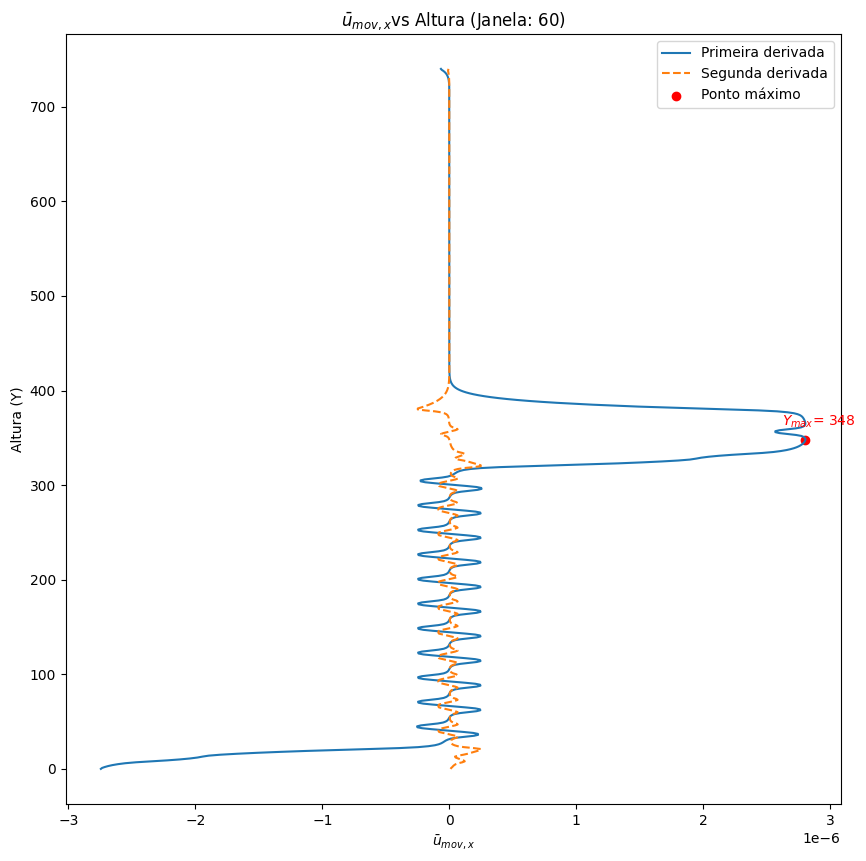

(400, 800, 9)
(400, 800, 9)


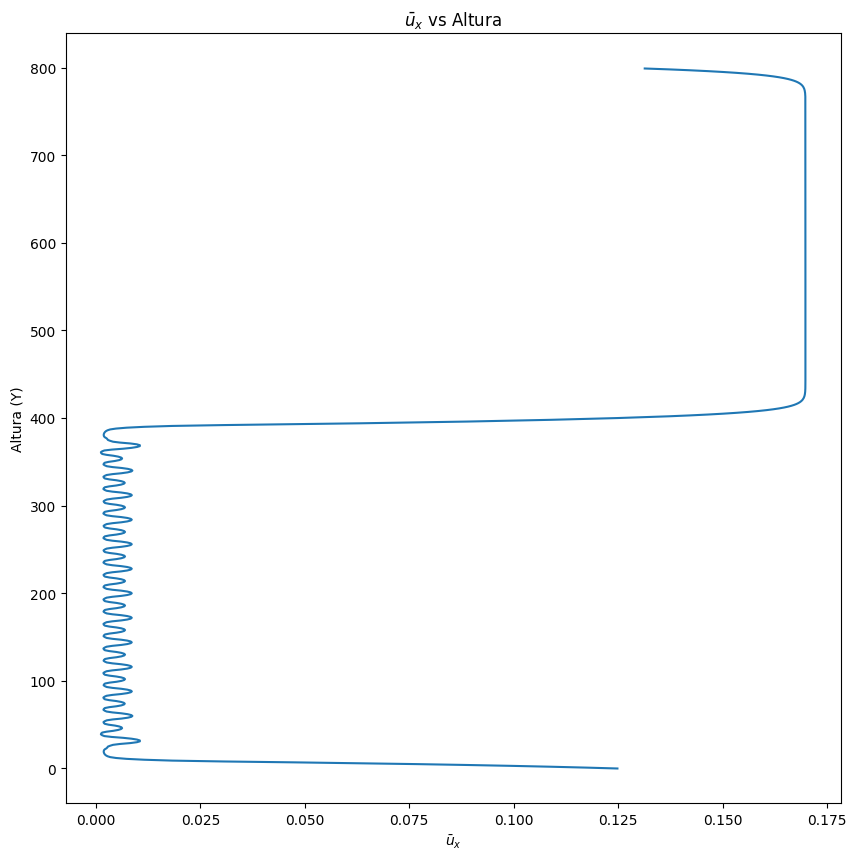

-3.5178403048814234e-05


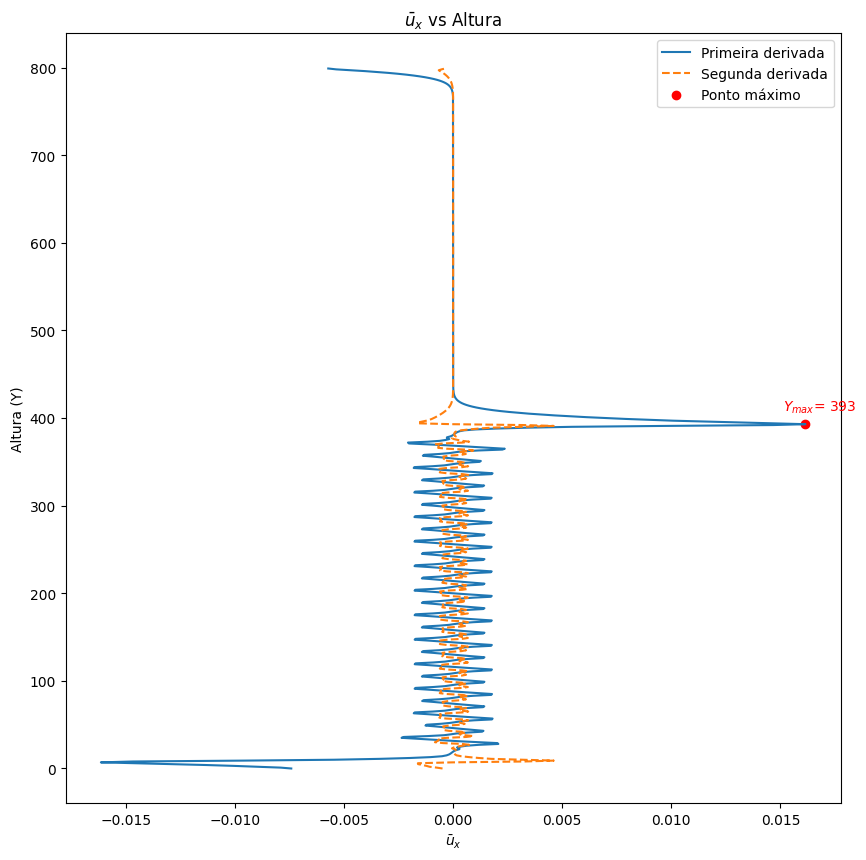

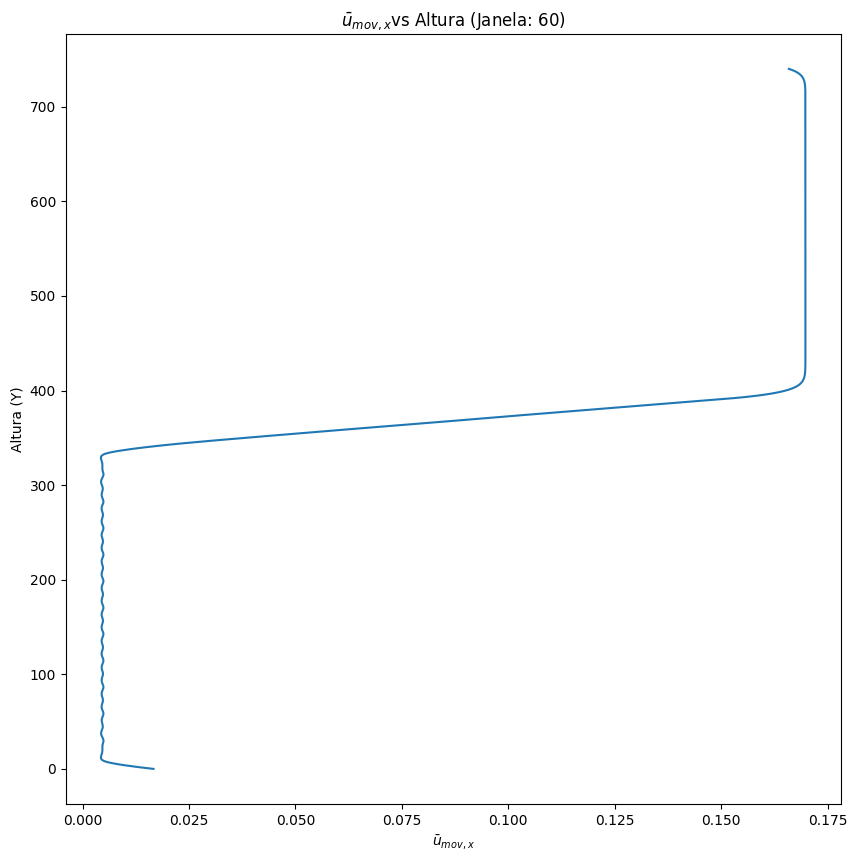

2.3385682540455477e-07


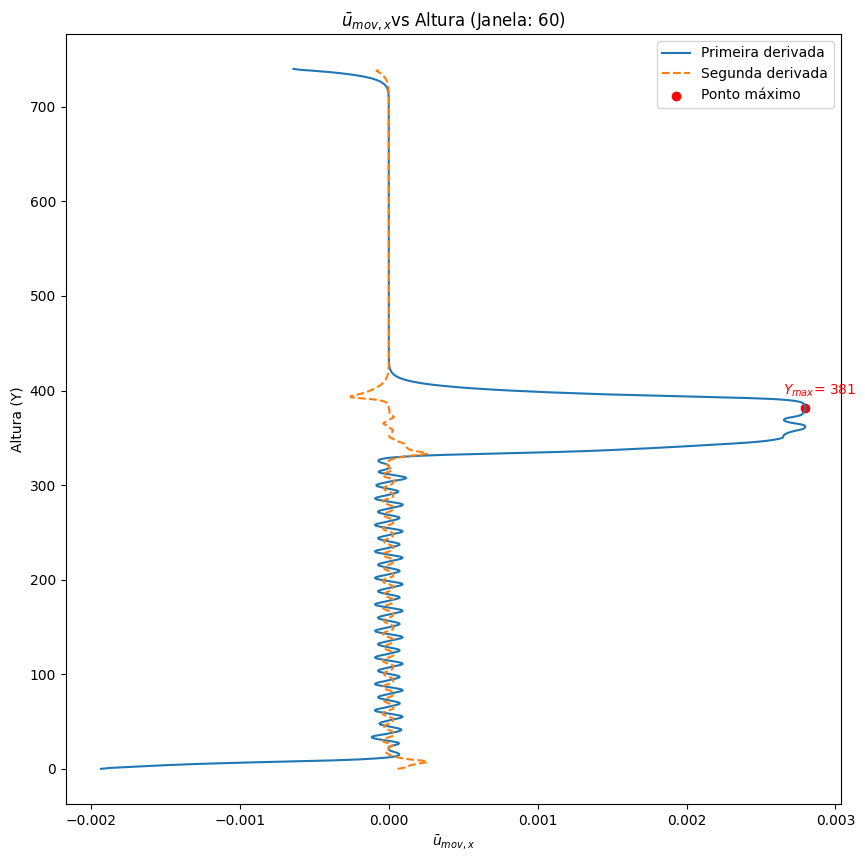

(400, 800, 9)
(400, 800, 9)


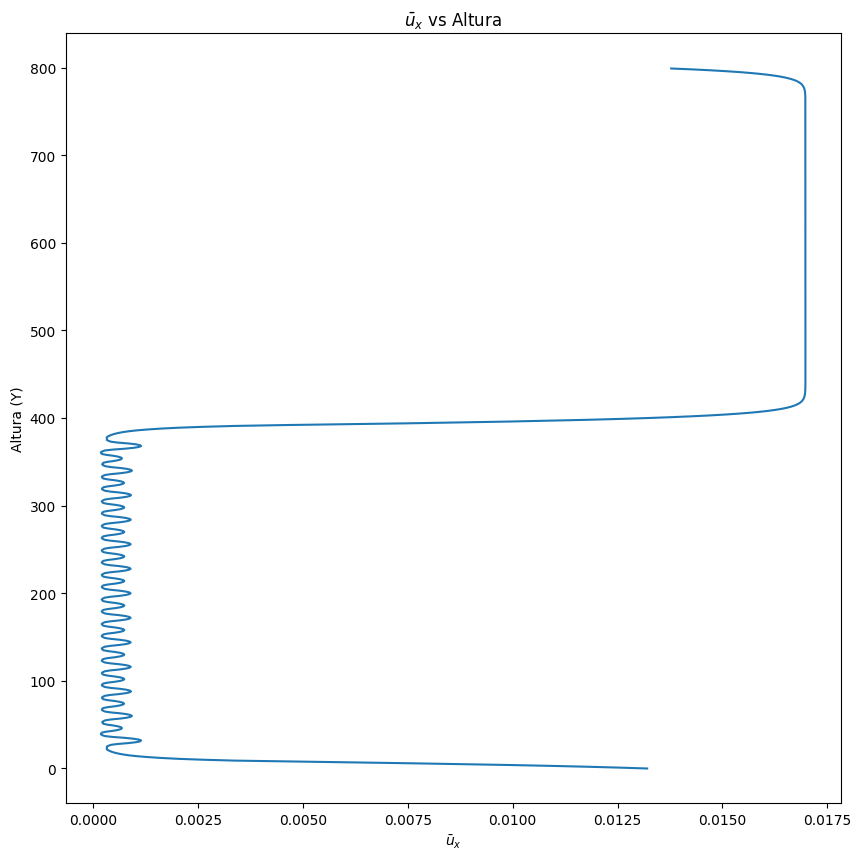

-1.7188835103566823e-05


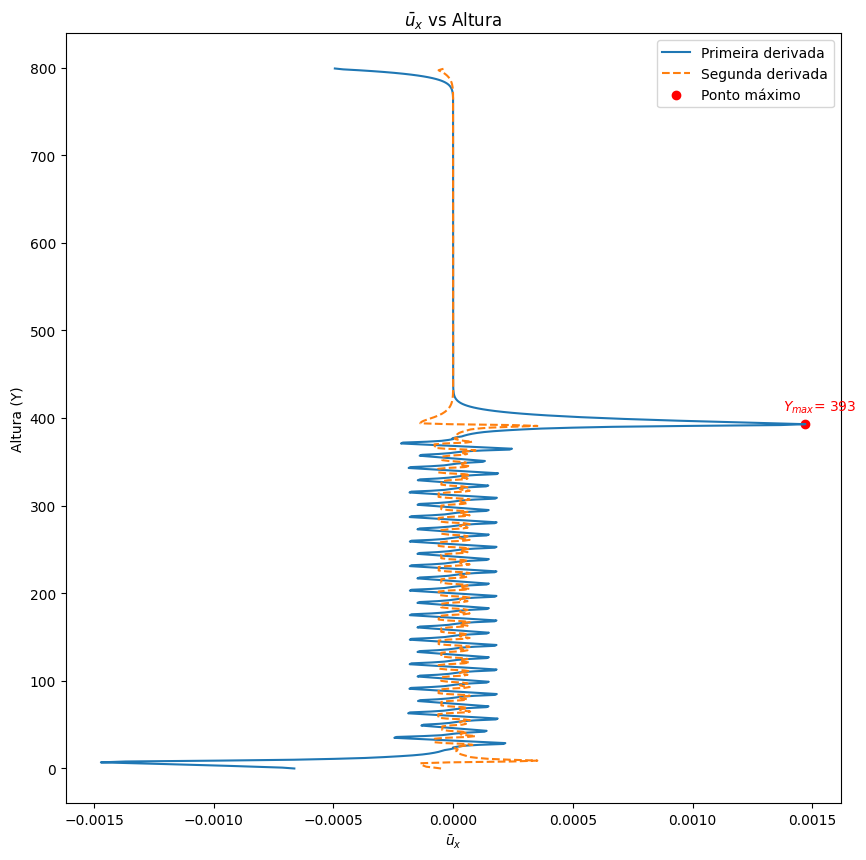

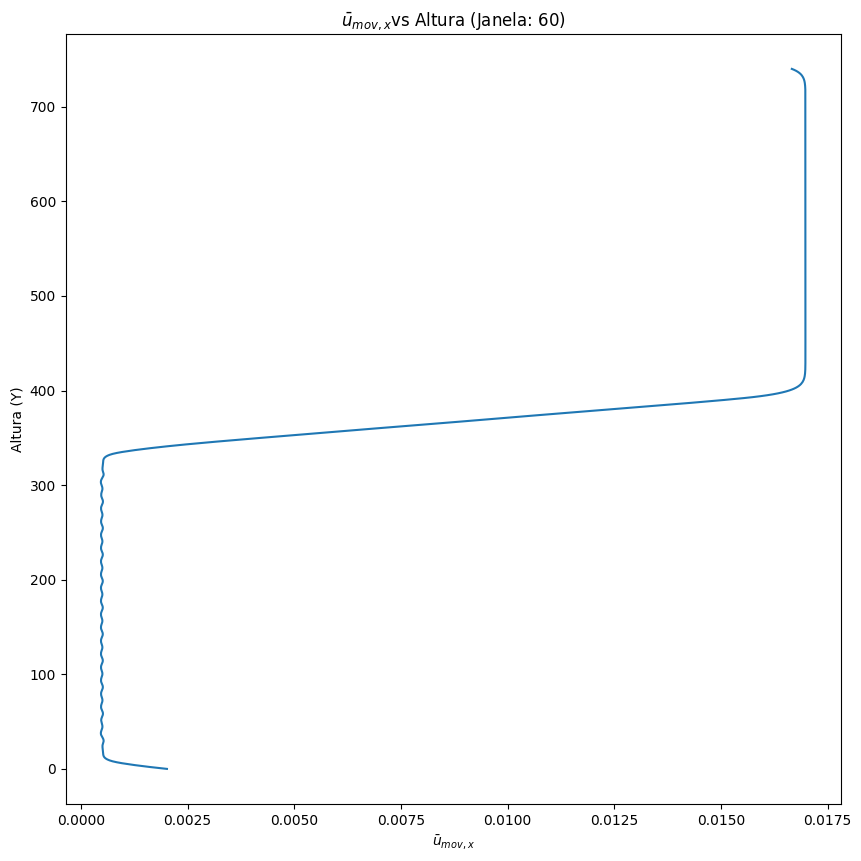

2.4623664864704617e-07


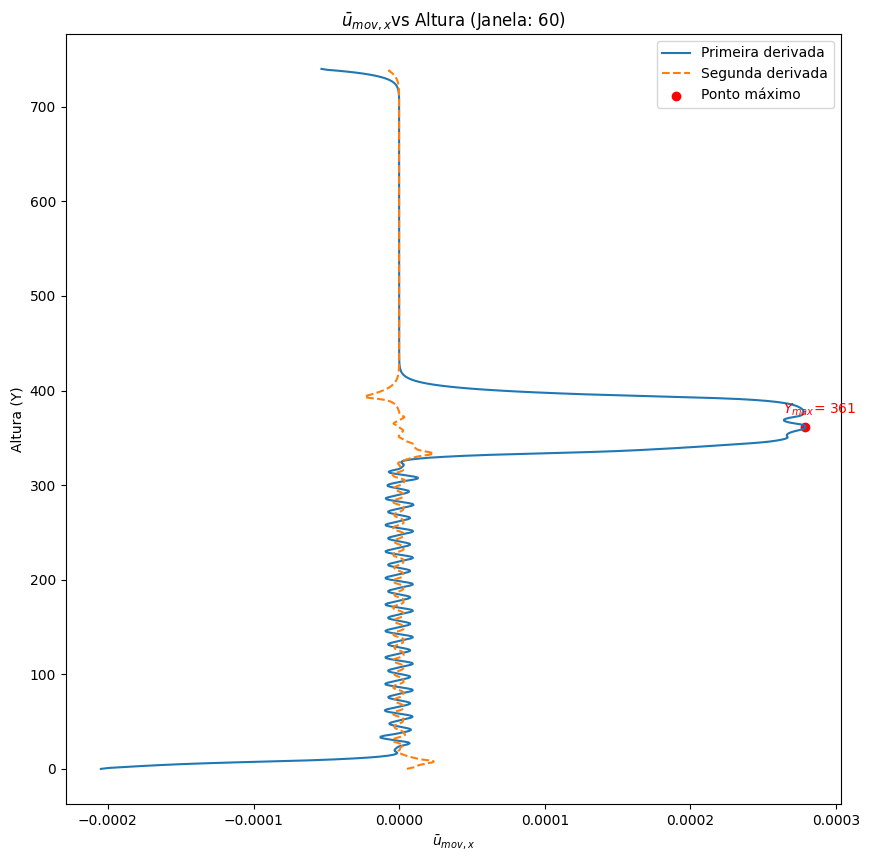

(400, 800, 9)
(400, 800, 9)


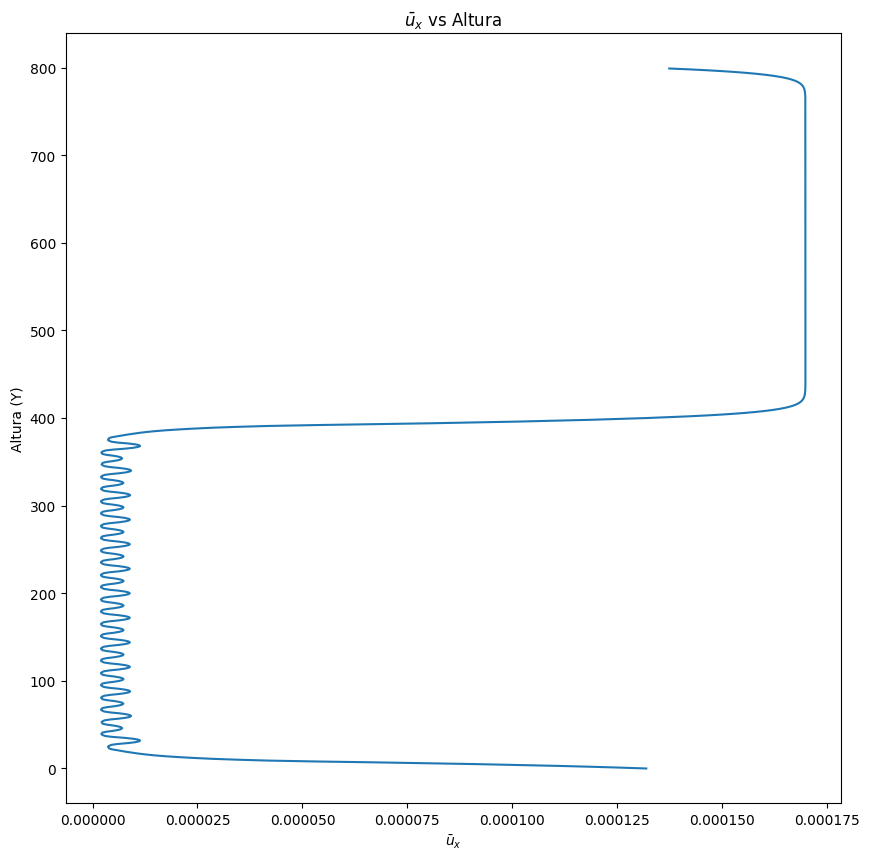

-3.140745412022892e-07


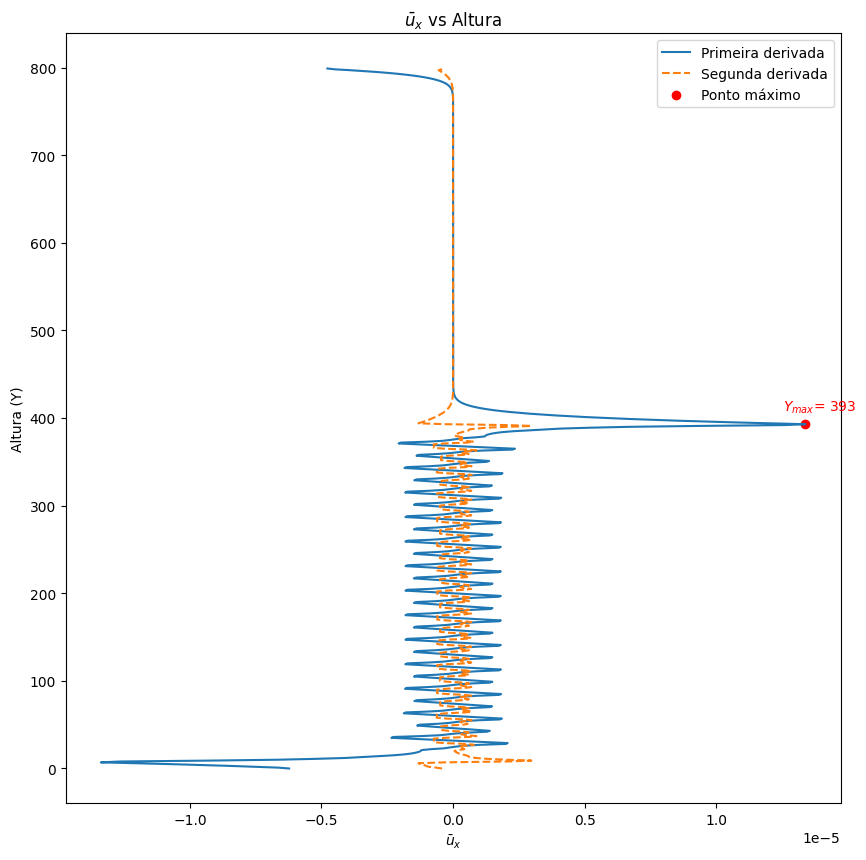

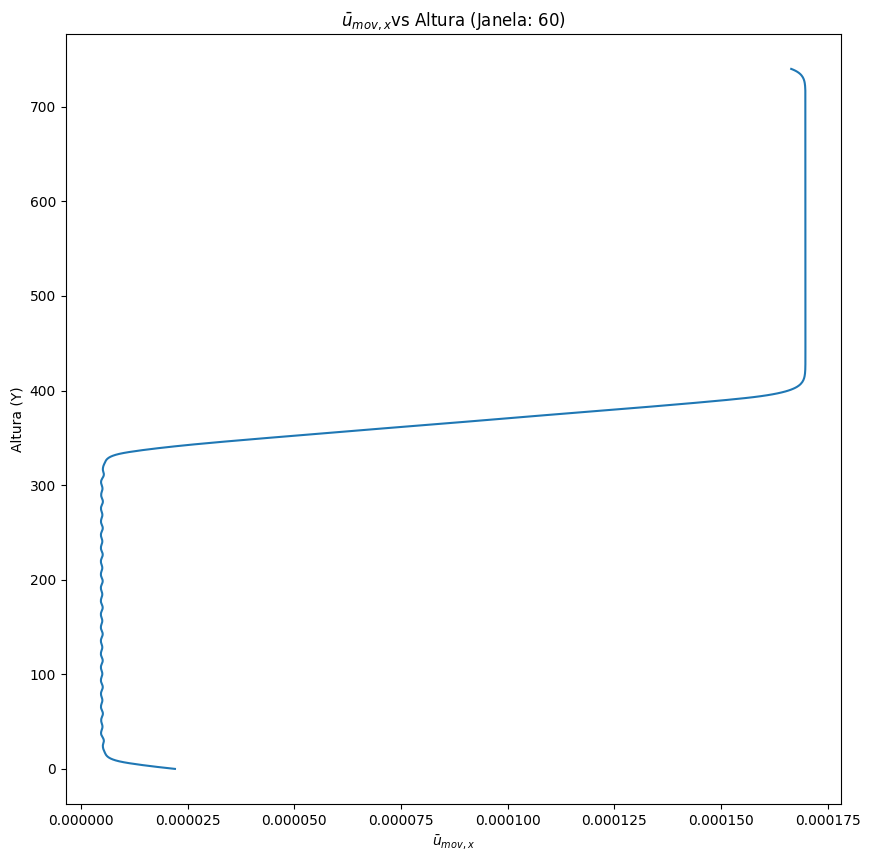

2.488709865704935e-09


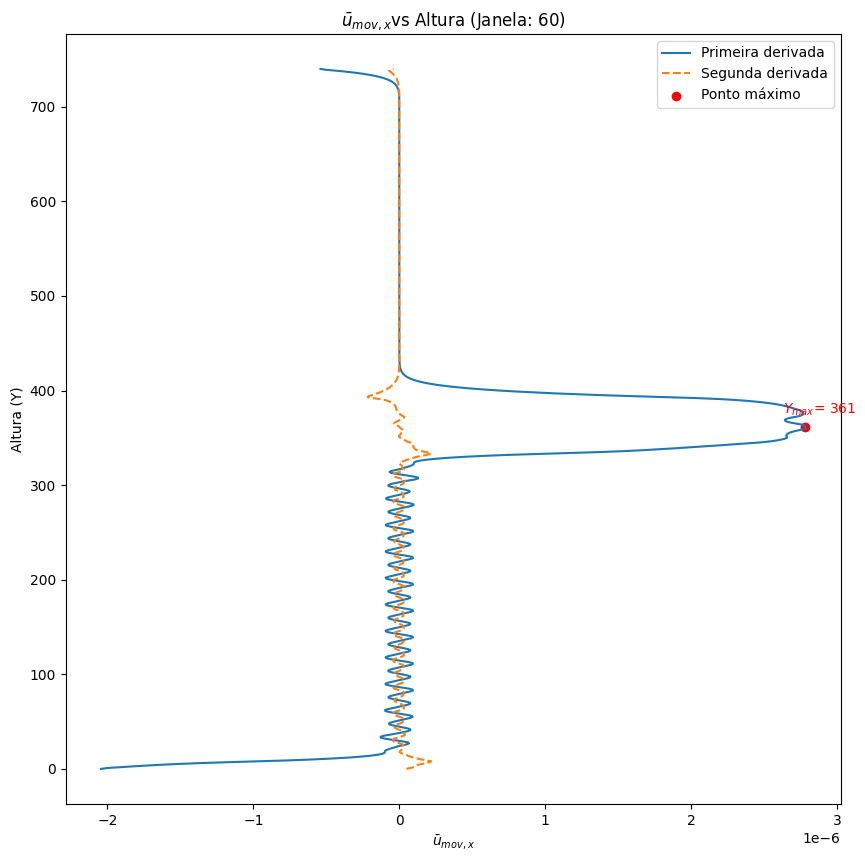

(400, 800, 9)
(400, 800, 9)


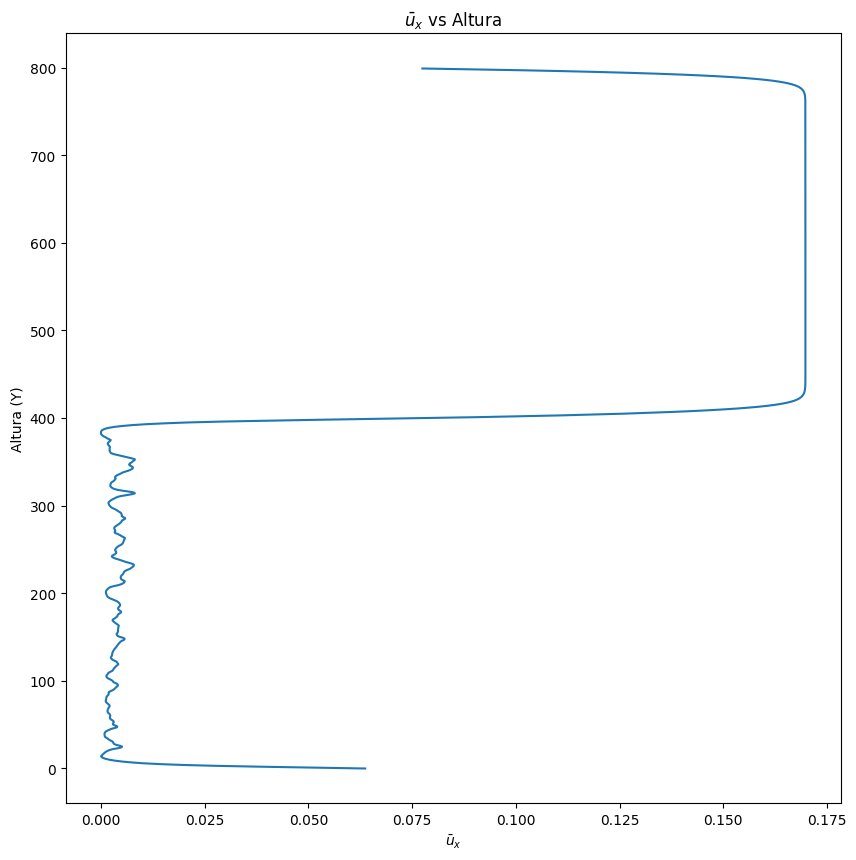

0.00013790202113846996


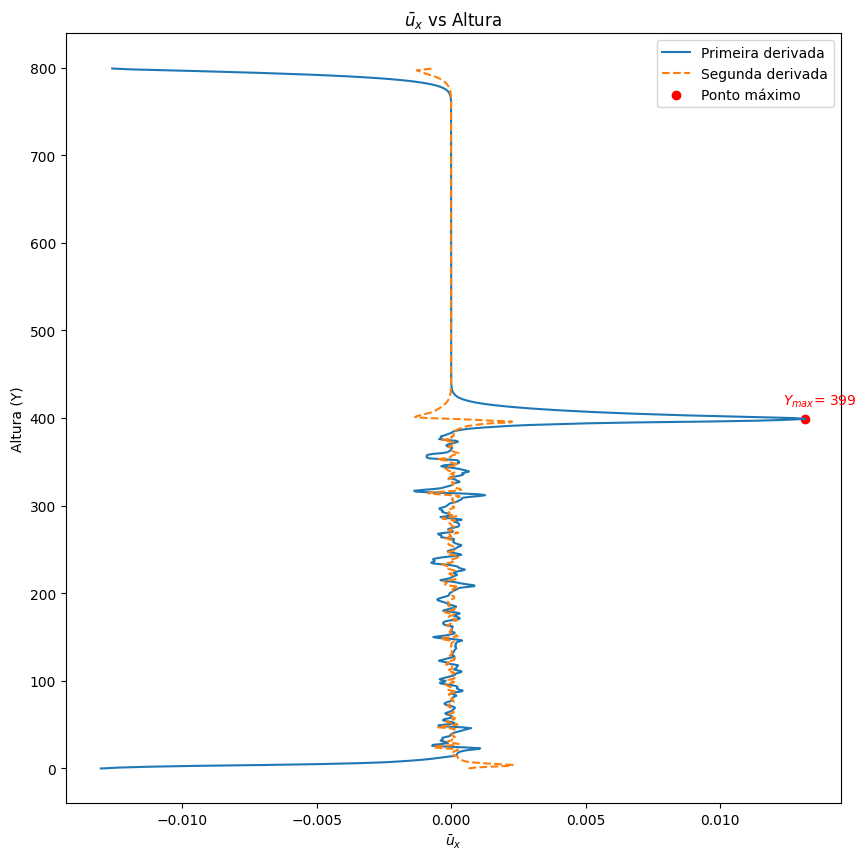

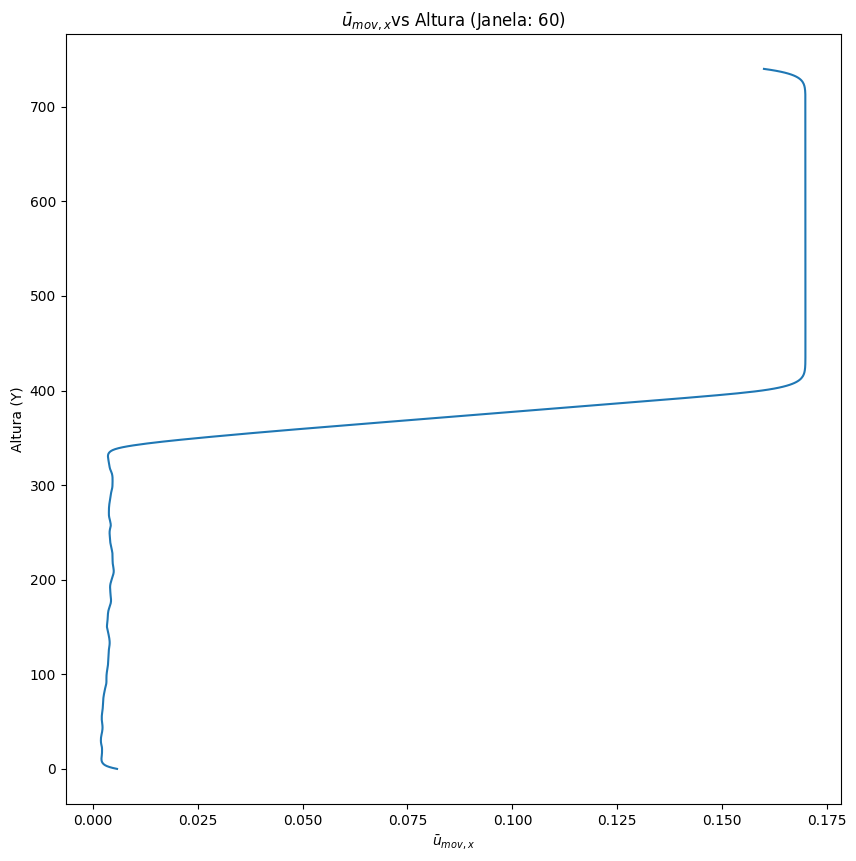

-3.2350107879997037e-07


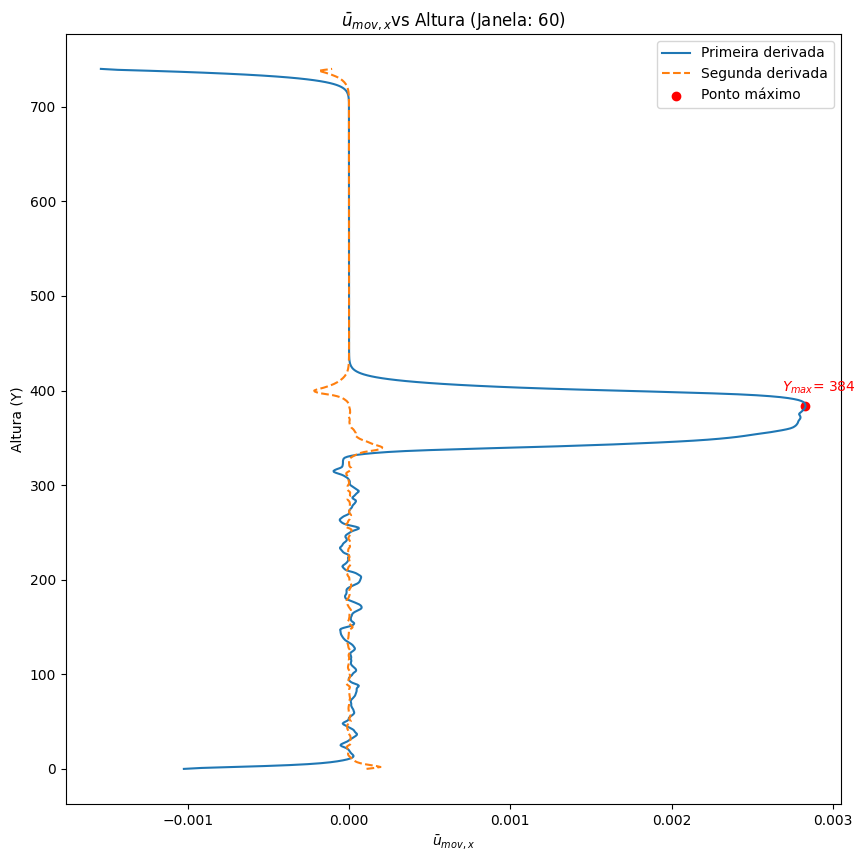

(400, 800, 9)
(400, 800, 9)


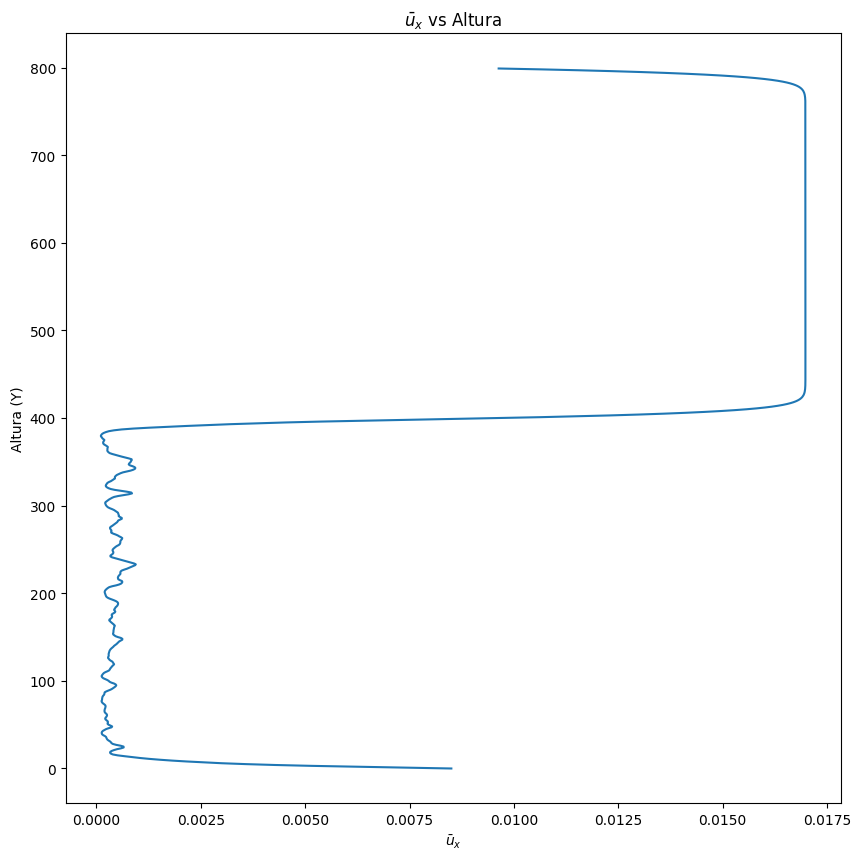

-7.1482573363364915e-06


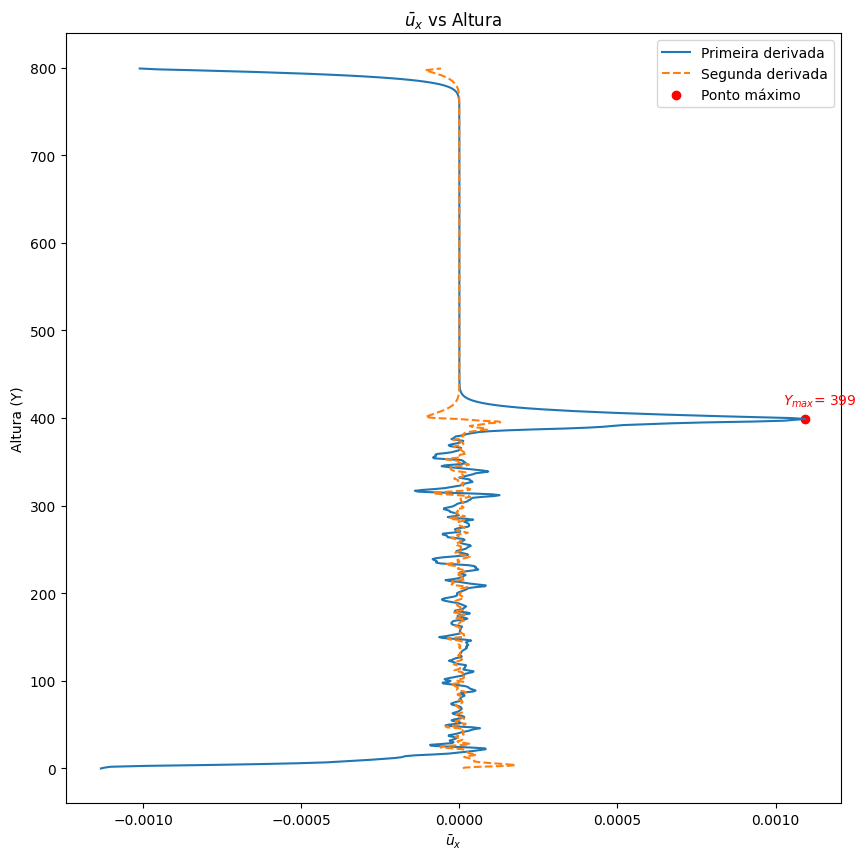

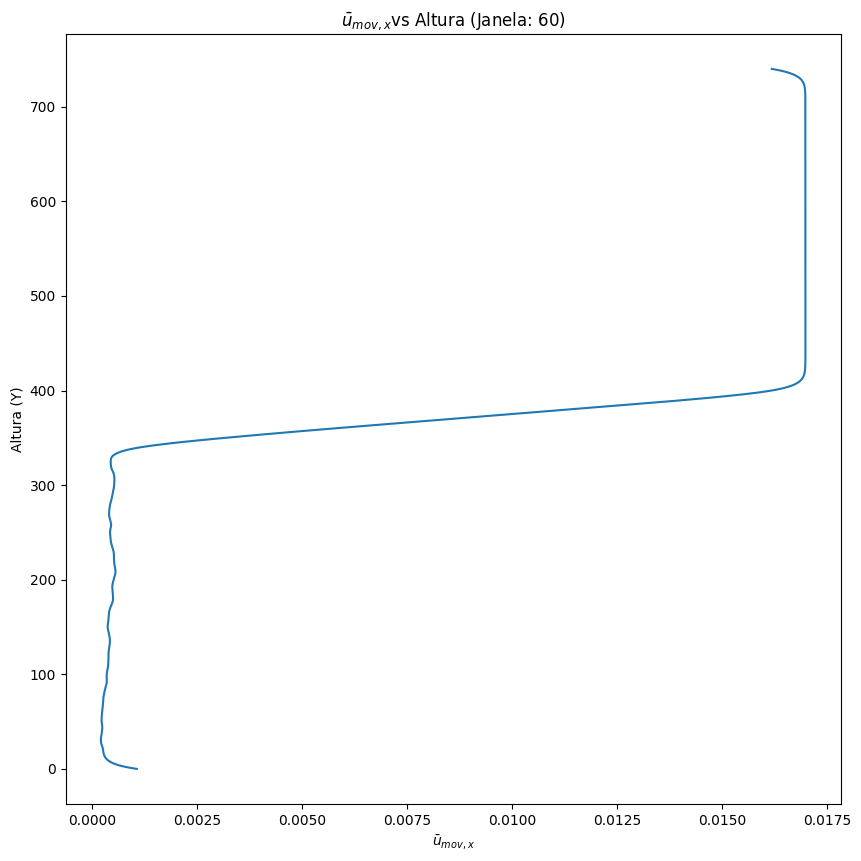

5.286860946815755e-08


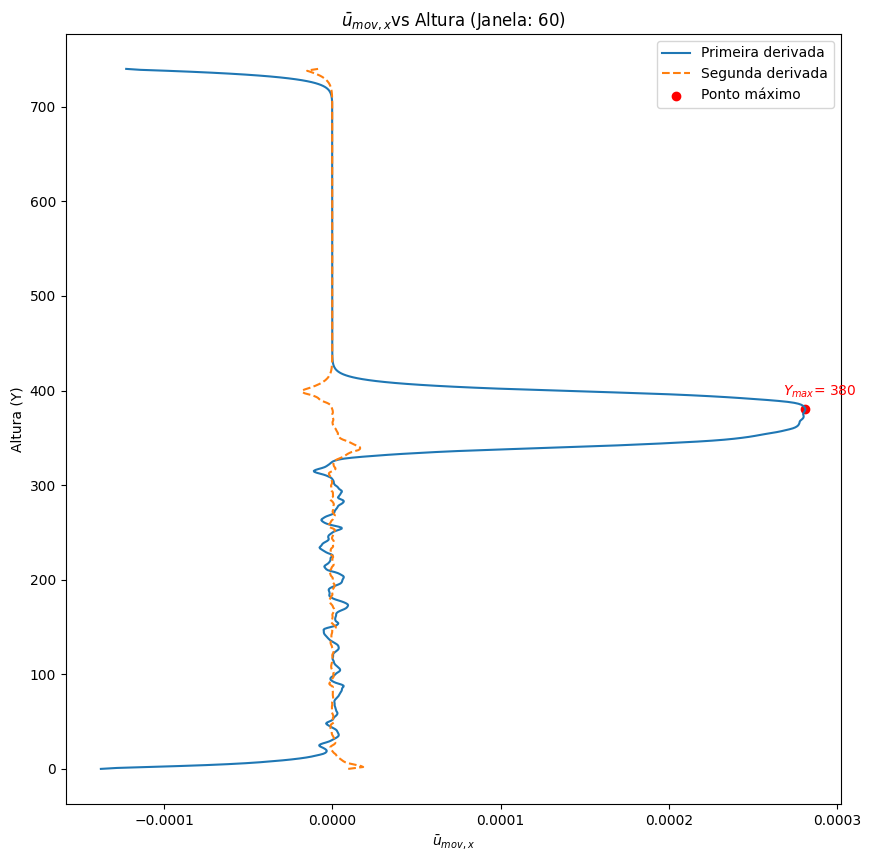

(400, 800, 9)
(400, 800, 9)


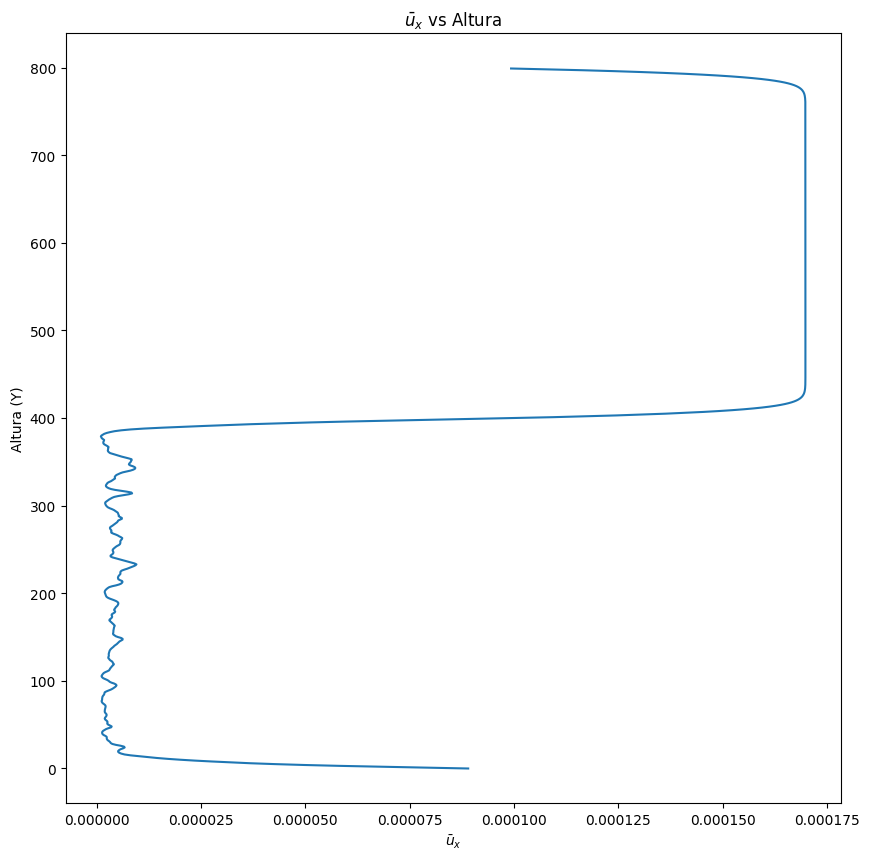

-2.6278009522359187e-07


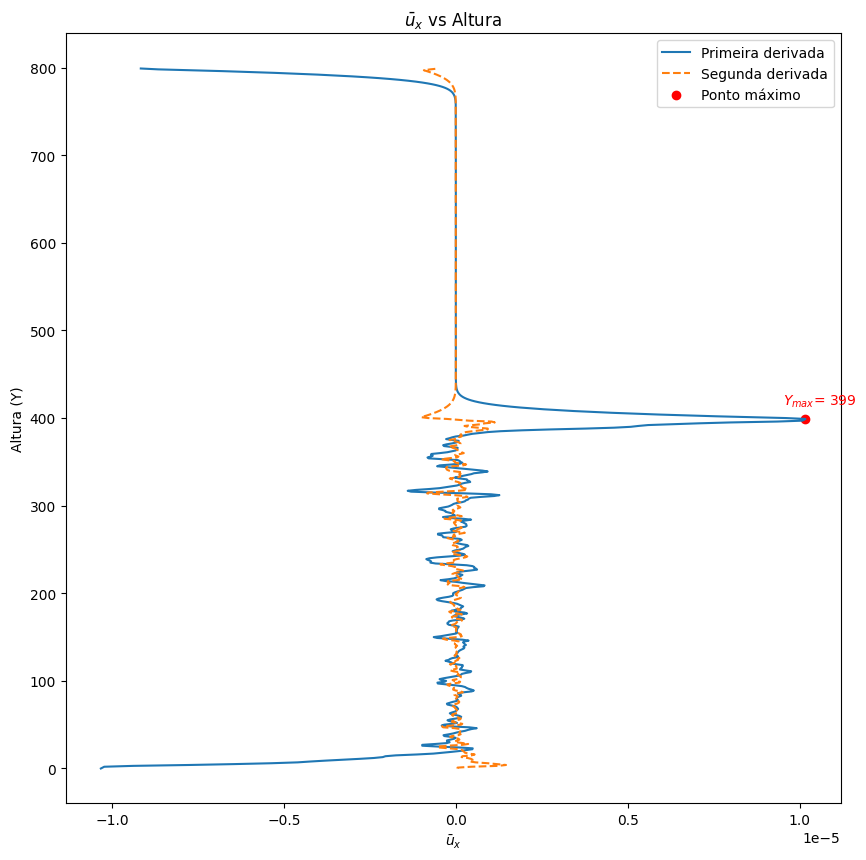

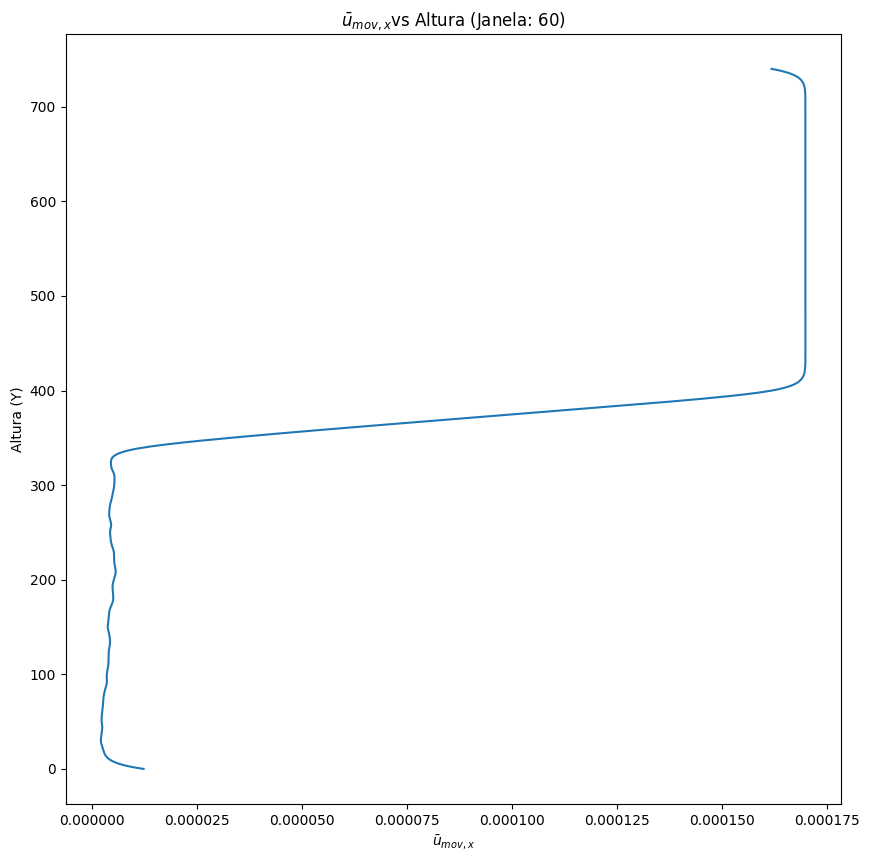

-1.7775662452396146e-09


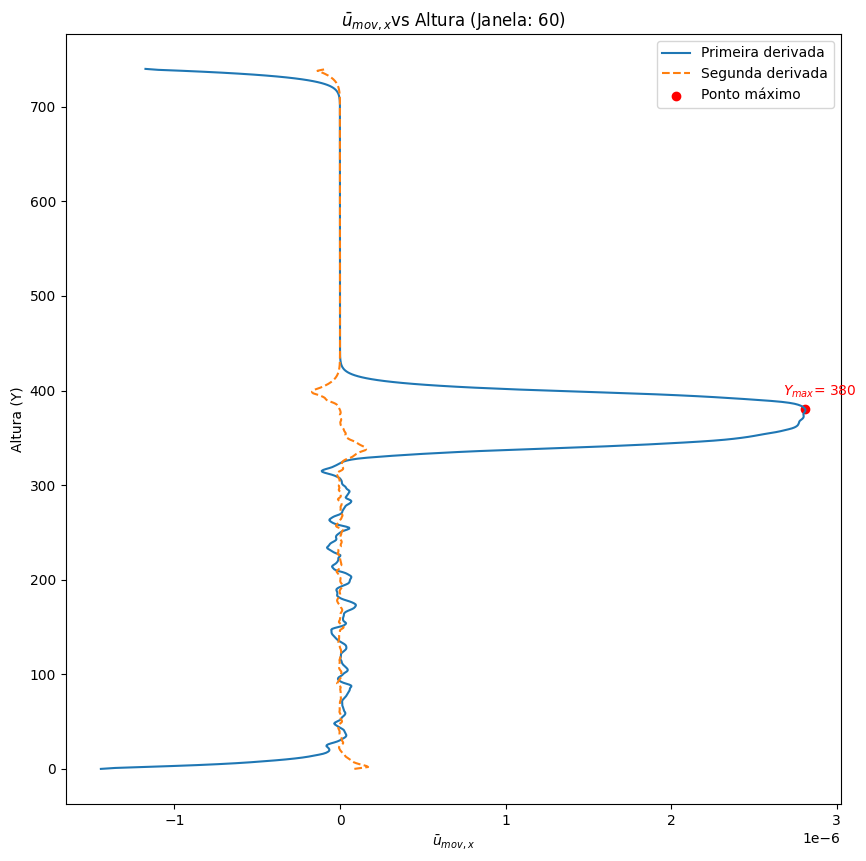

(400, 800, 9)
(400, 800, 9)


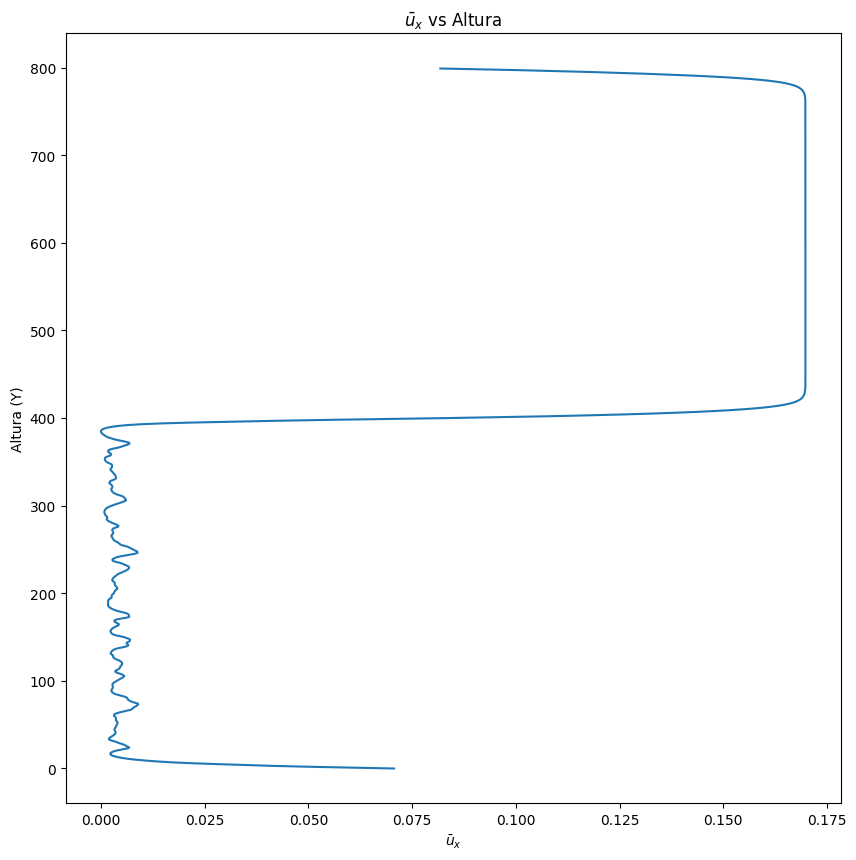

-3.72477890855788e-05


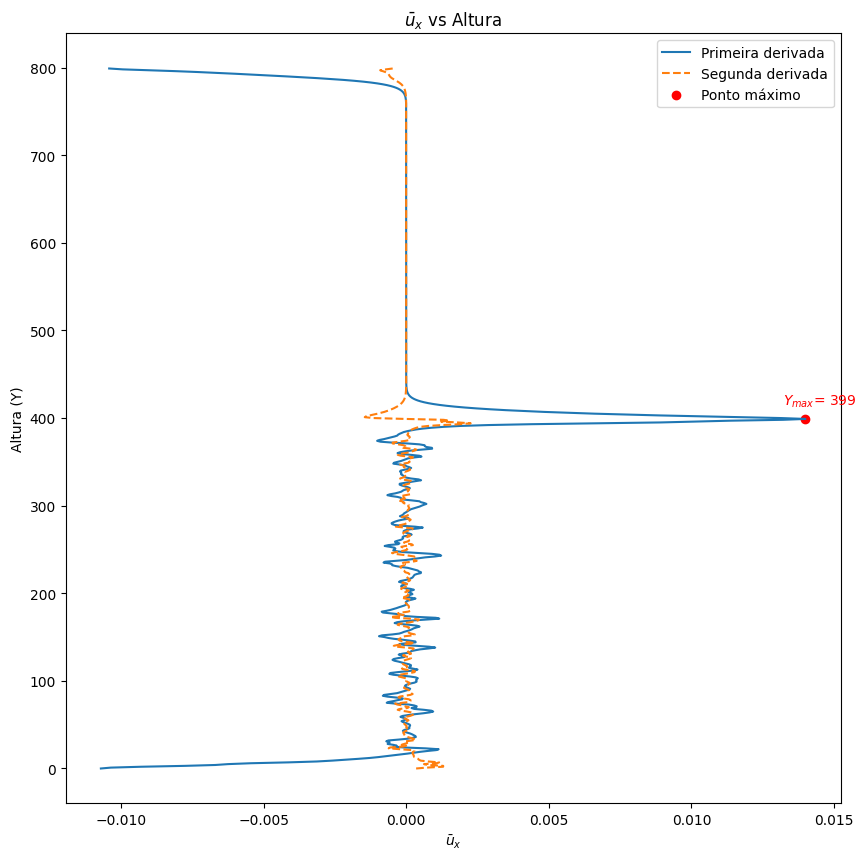

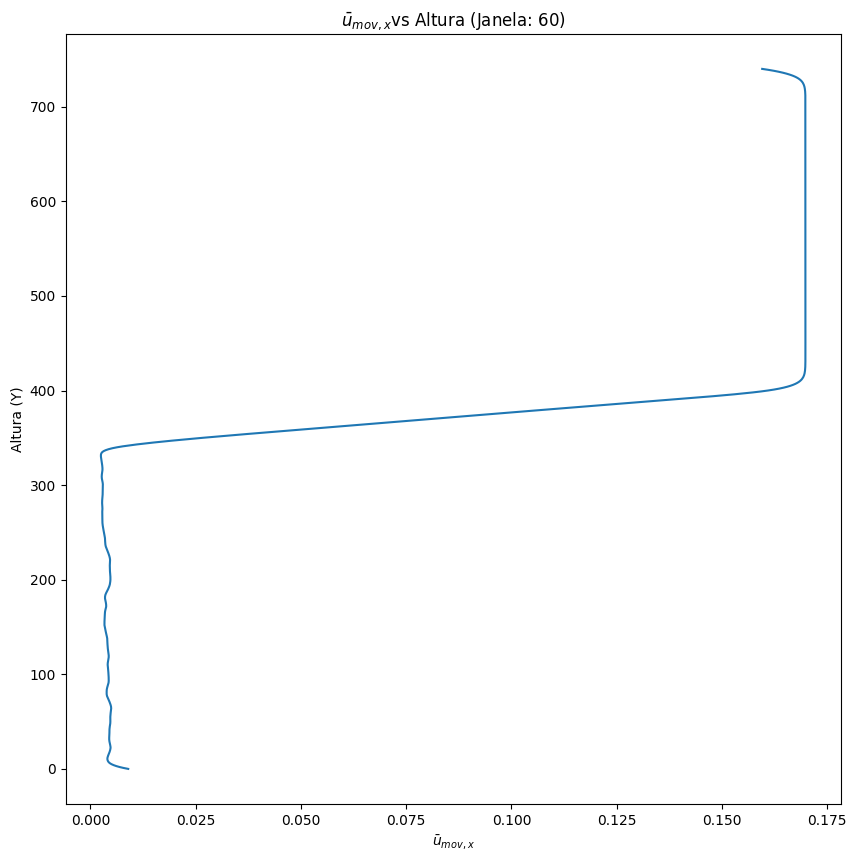

4.575998460744357e-07


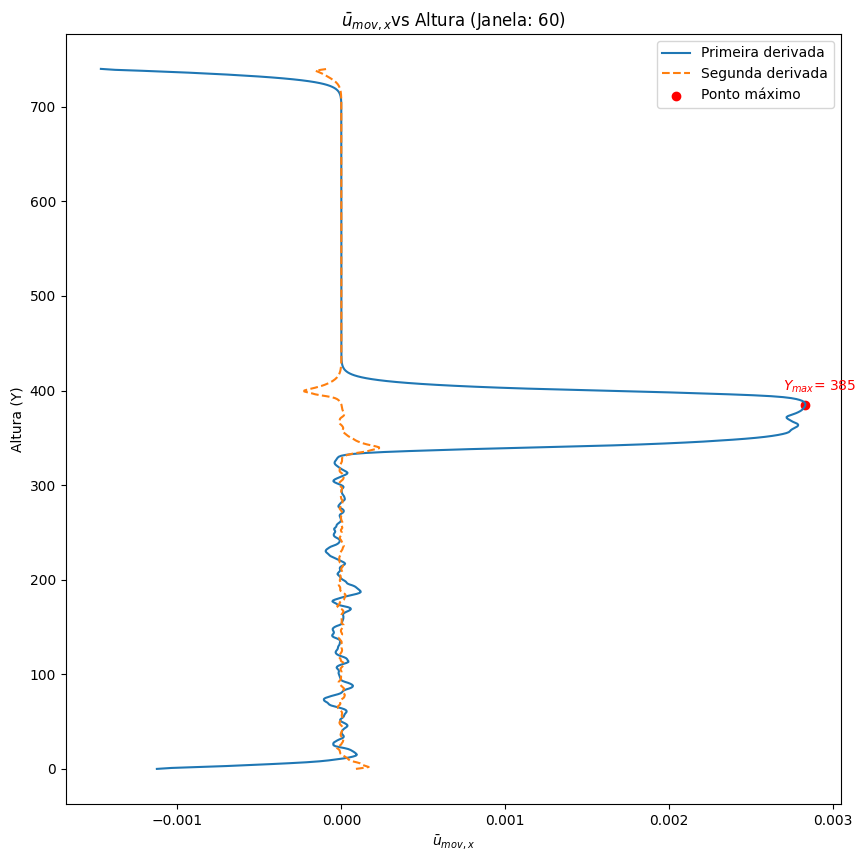

(400, 800, 9)
(400, 800, 9)


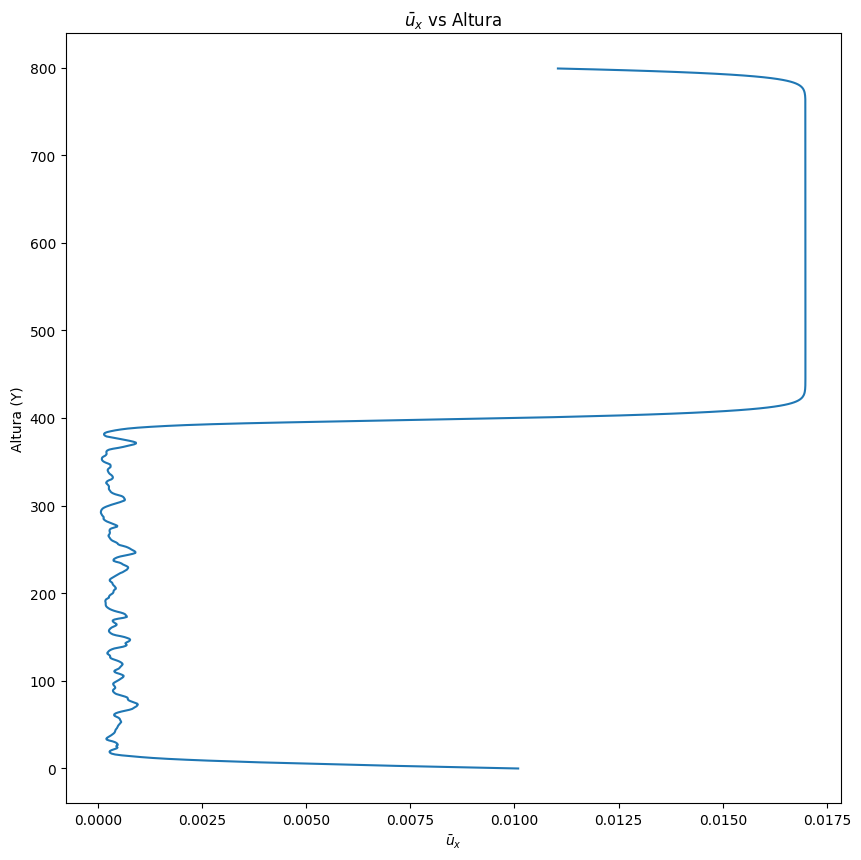

-4.457091465473982e-05


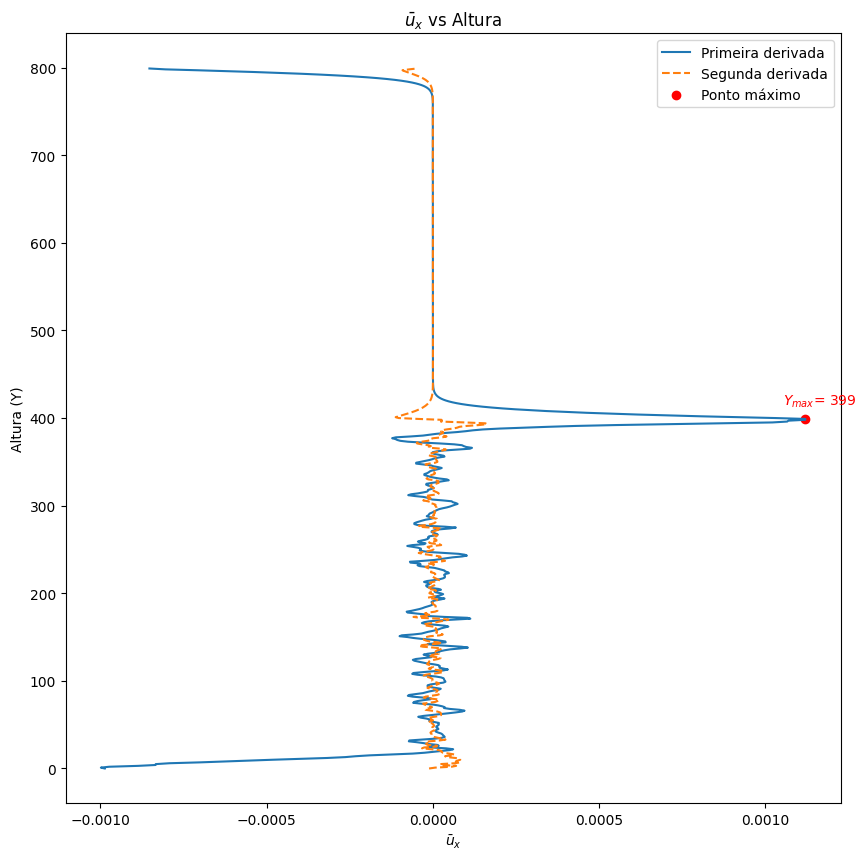

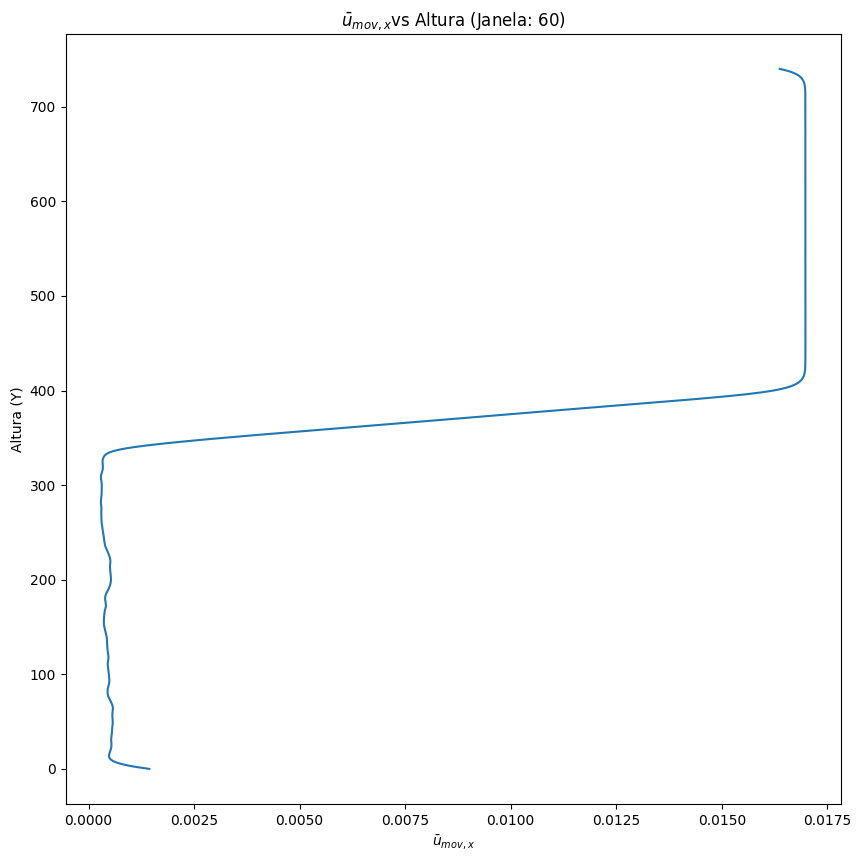

-9.225706175137321e-09


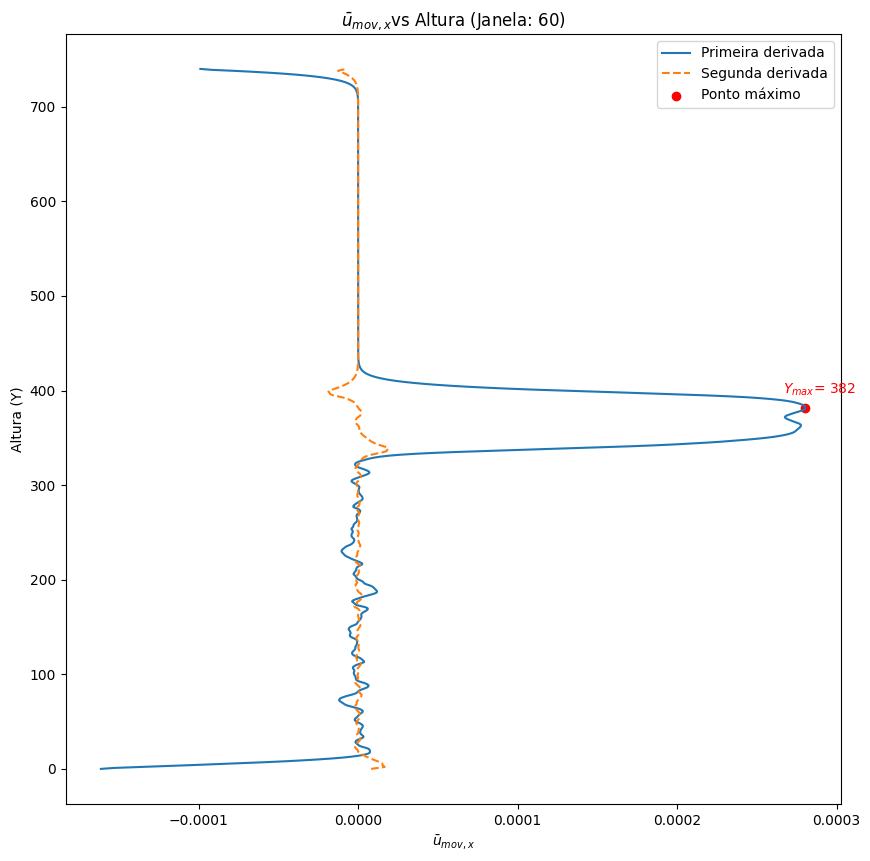

(400, 800, 9)
(400, 800, 9)


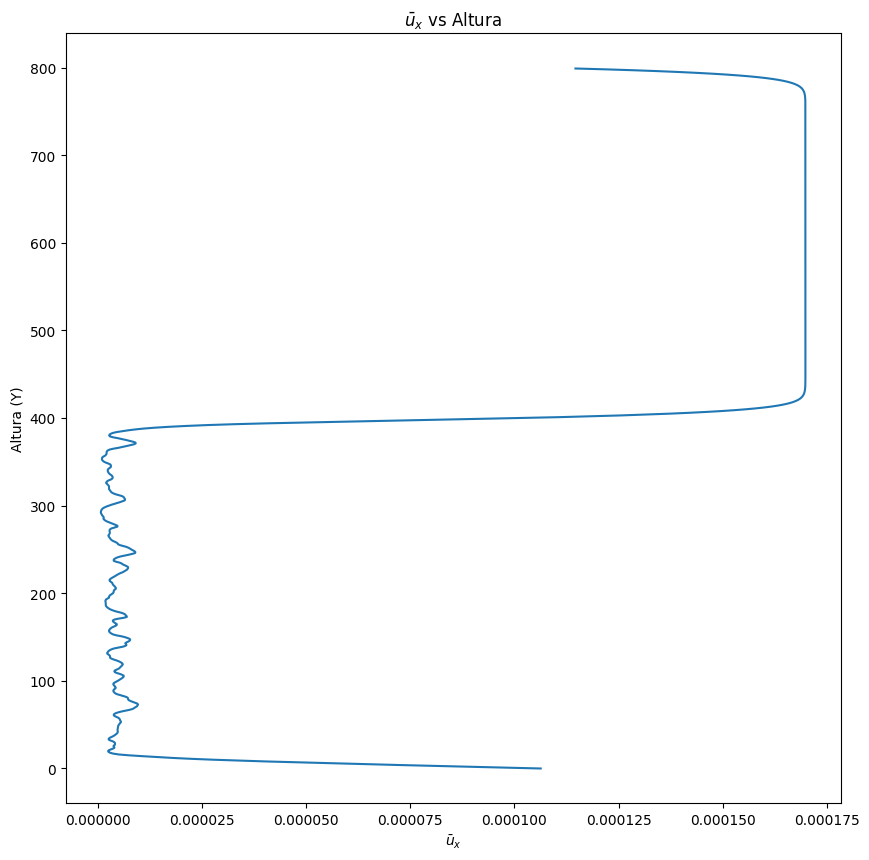

1.3171627909141287e-07


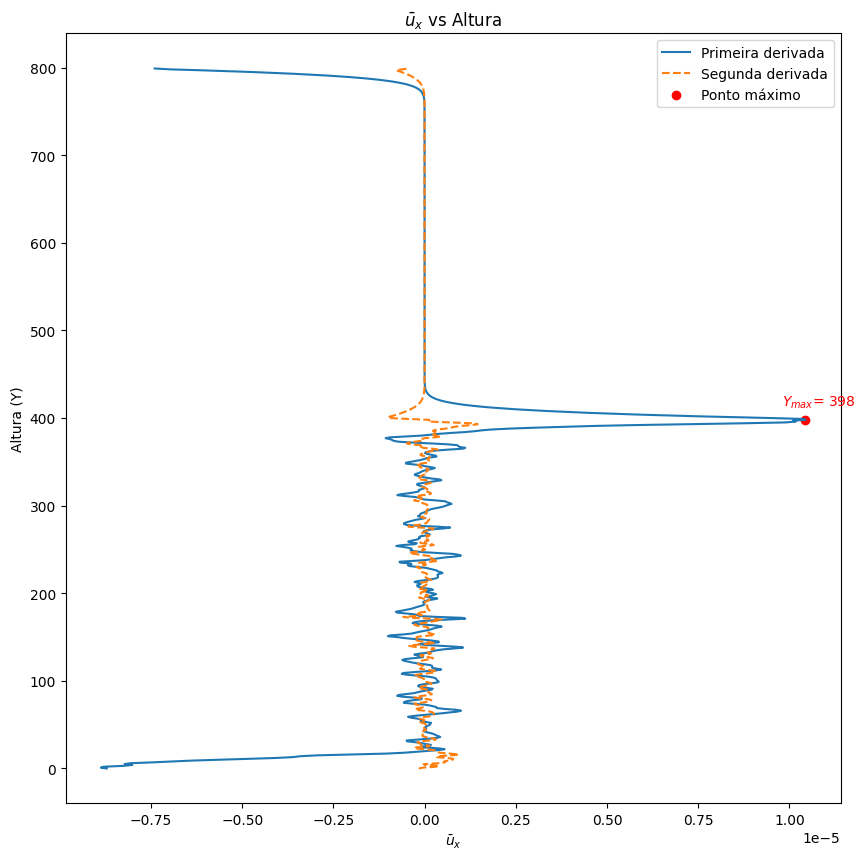

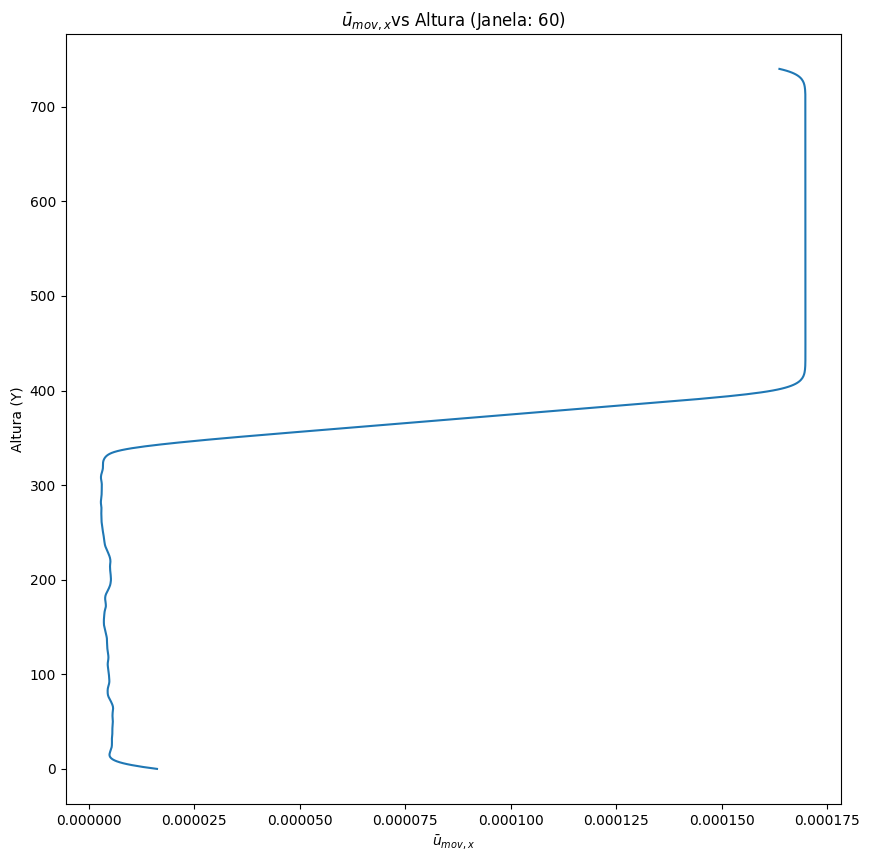

-8.086202766744073e-10


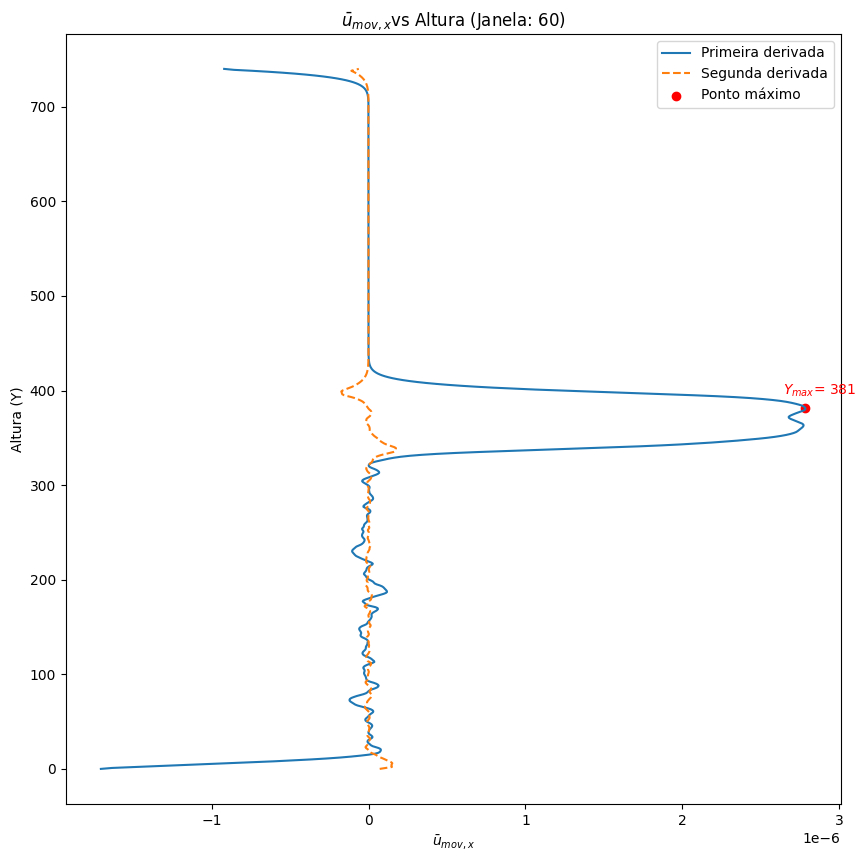

(400, 800, 9)
(400, 800, 9)


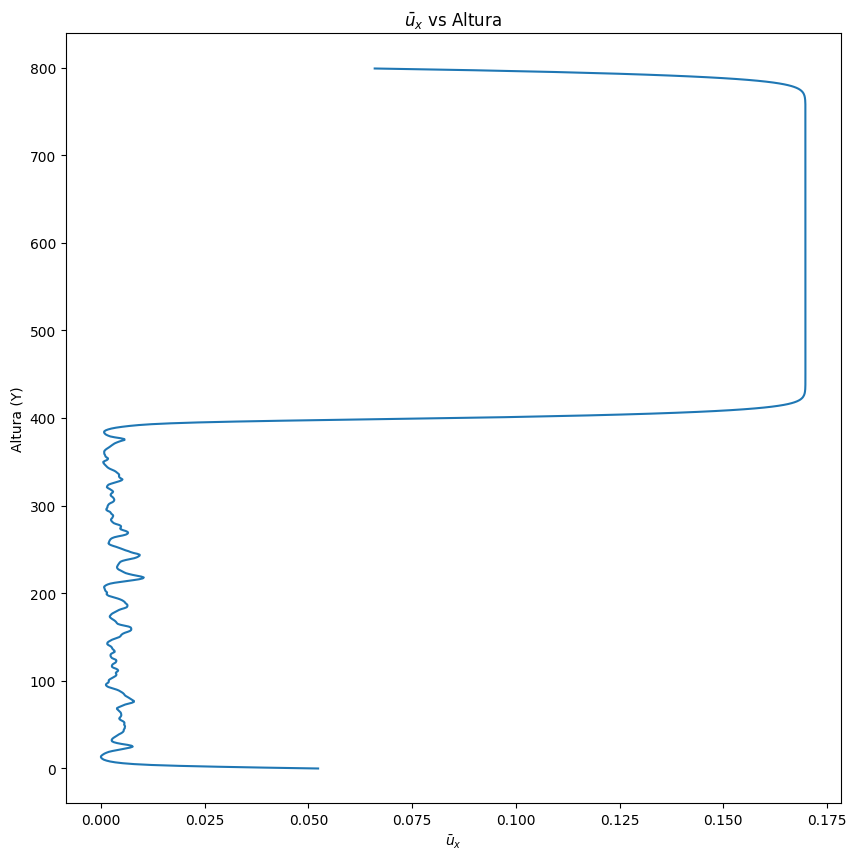

0.0007125613006789787


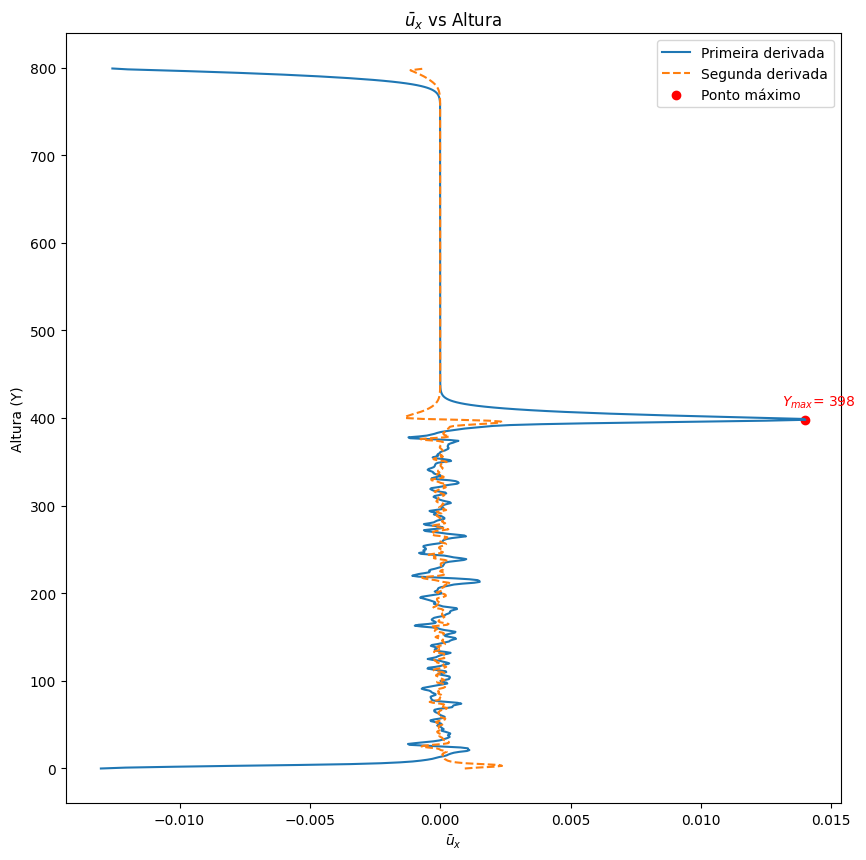

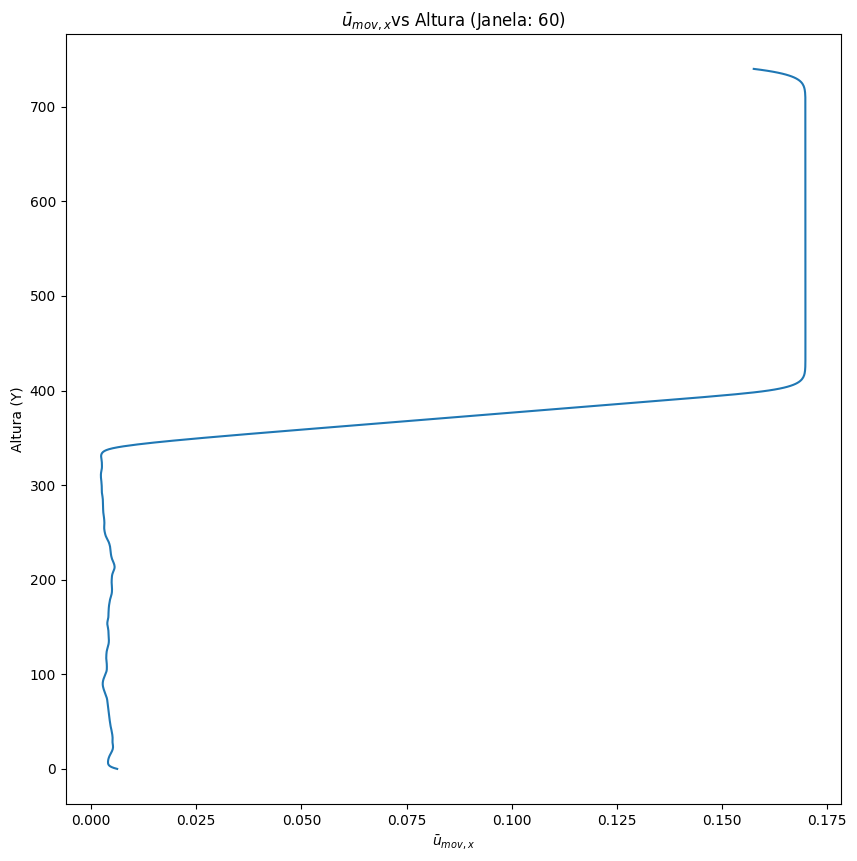

9.003315120485744e-07


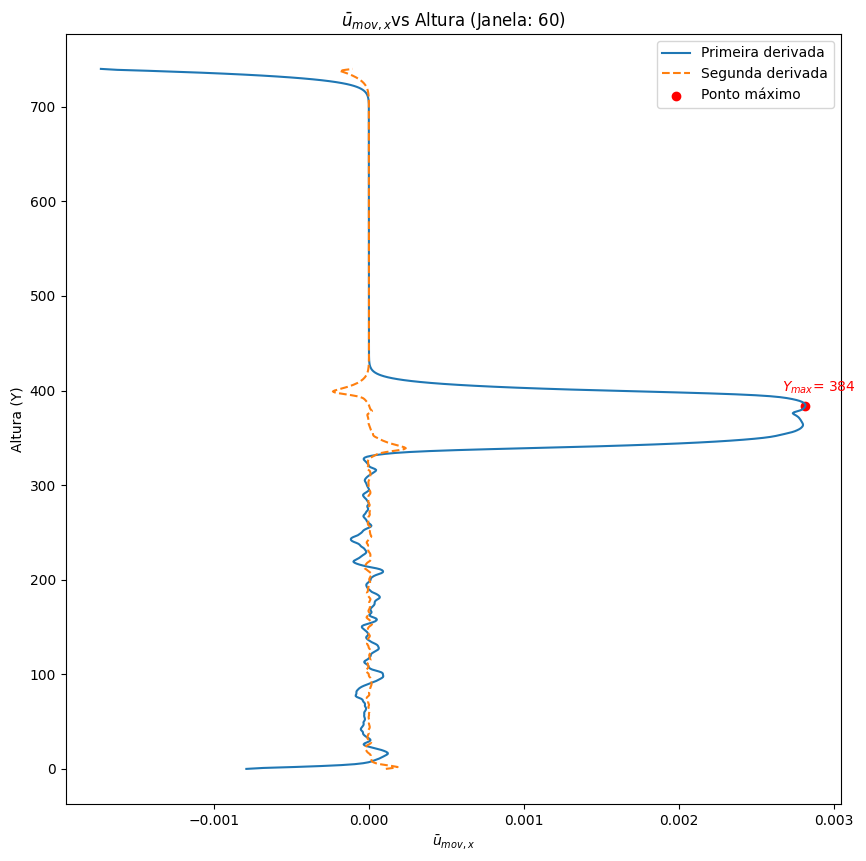

(400, 800, 9)
(400, 800, 9)


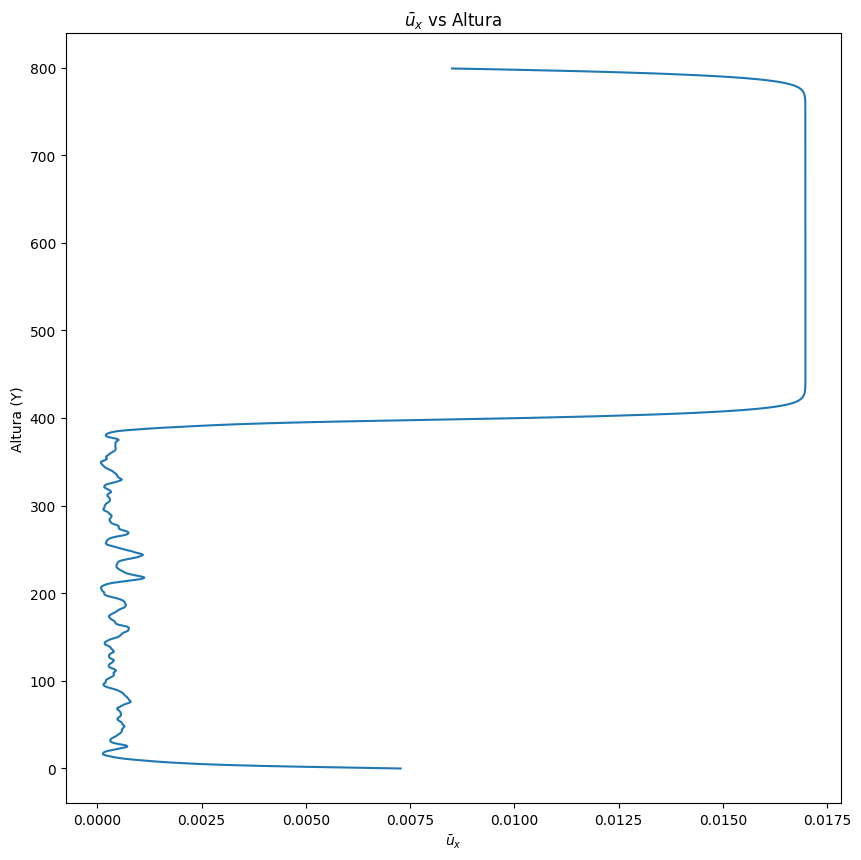

-4.130051625219049e-06


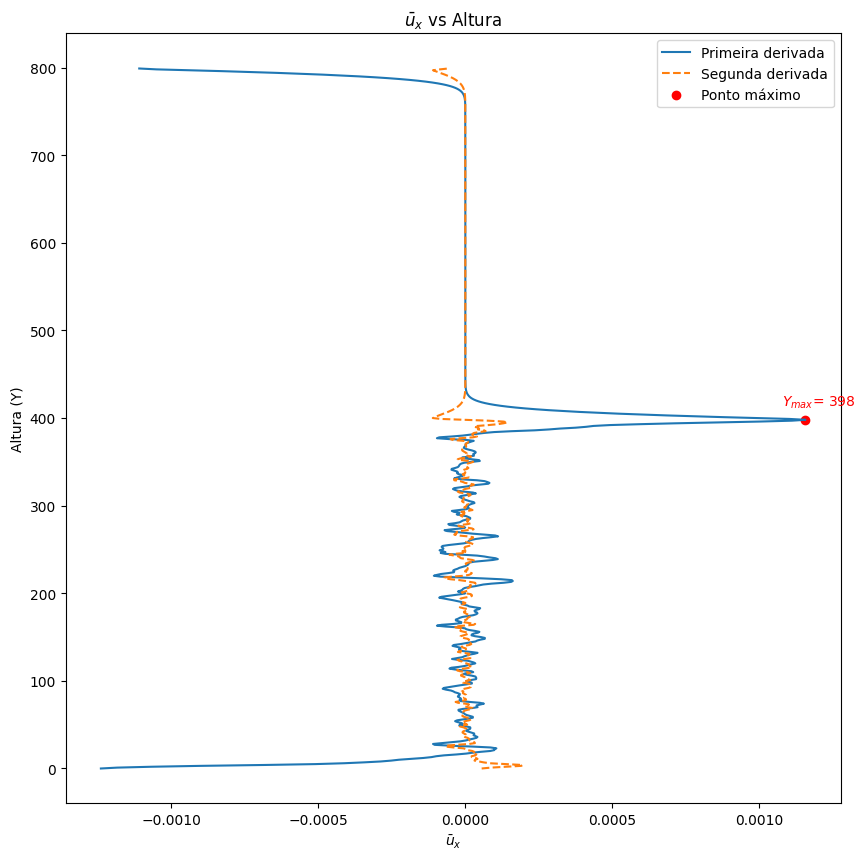

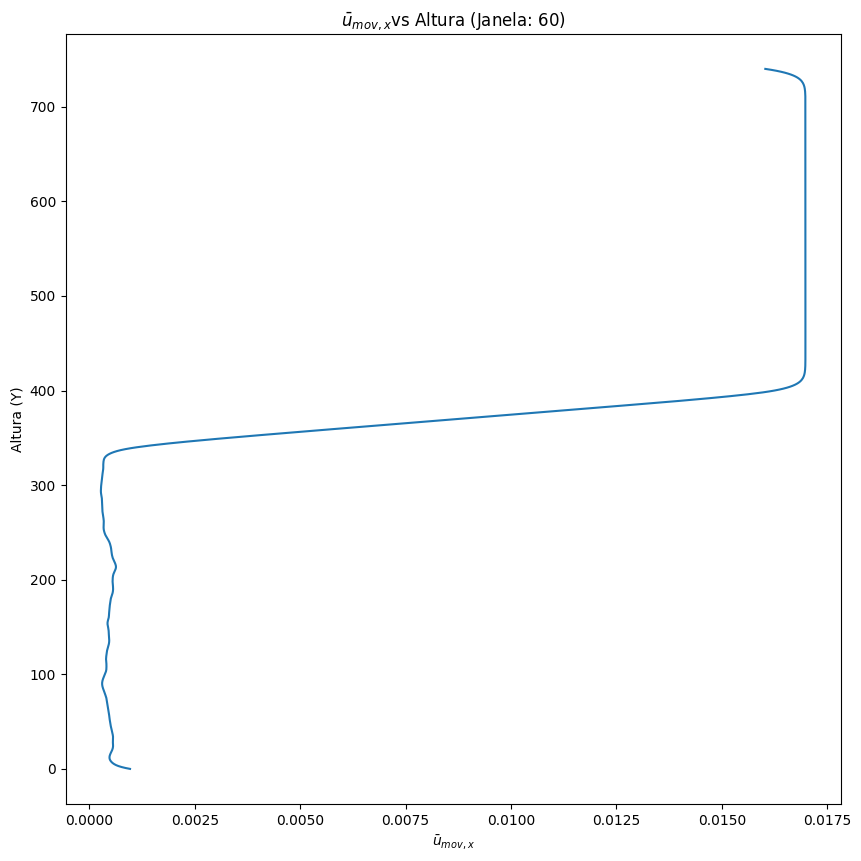

-4.95337833289651e-08


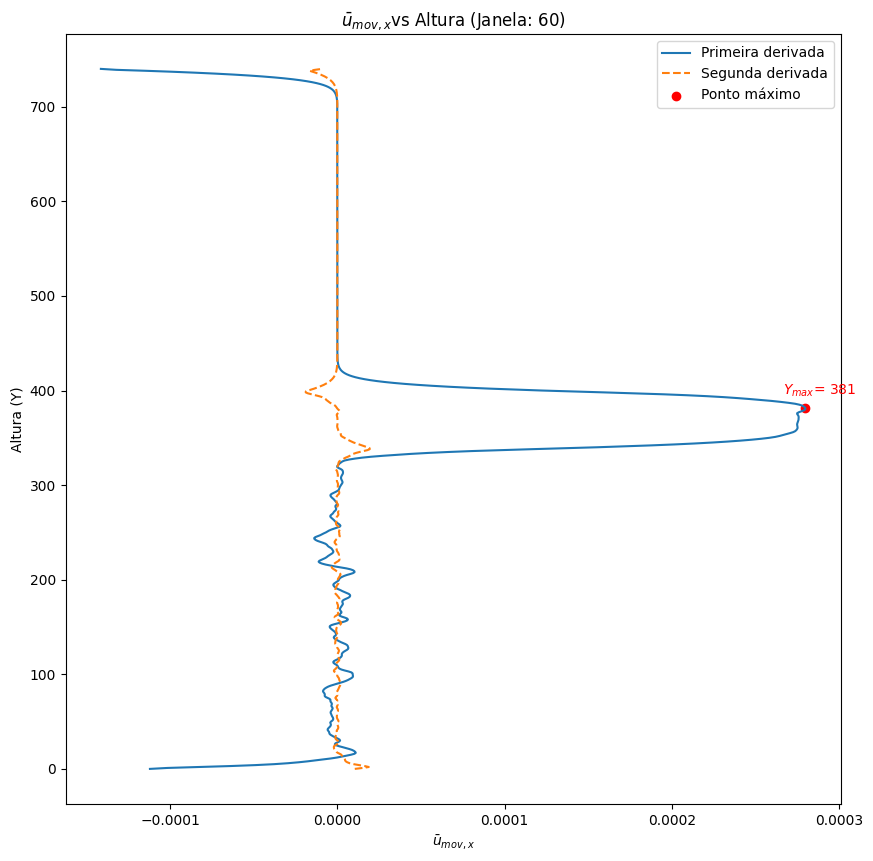

(400, 800, 9)
(400, 800, 9)


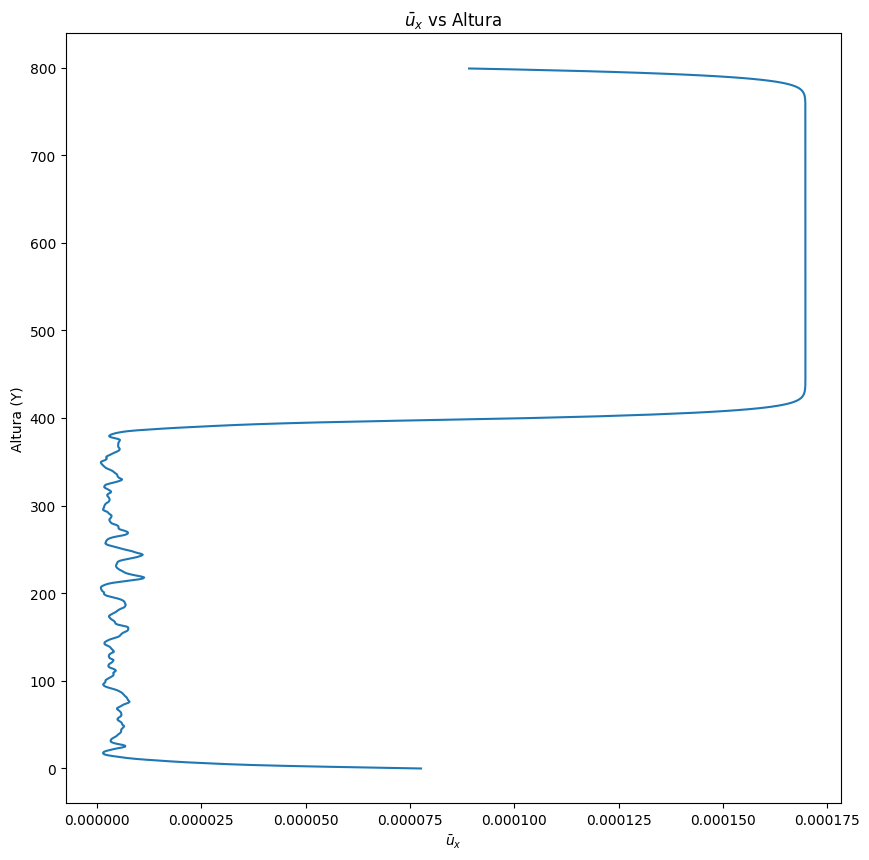

-1.859884857463123e-07


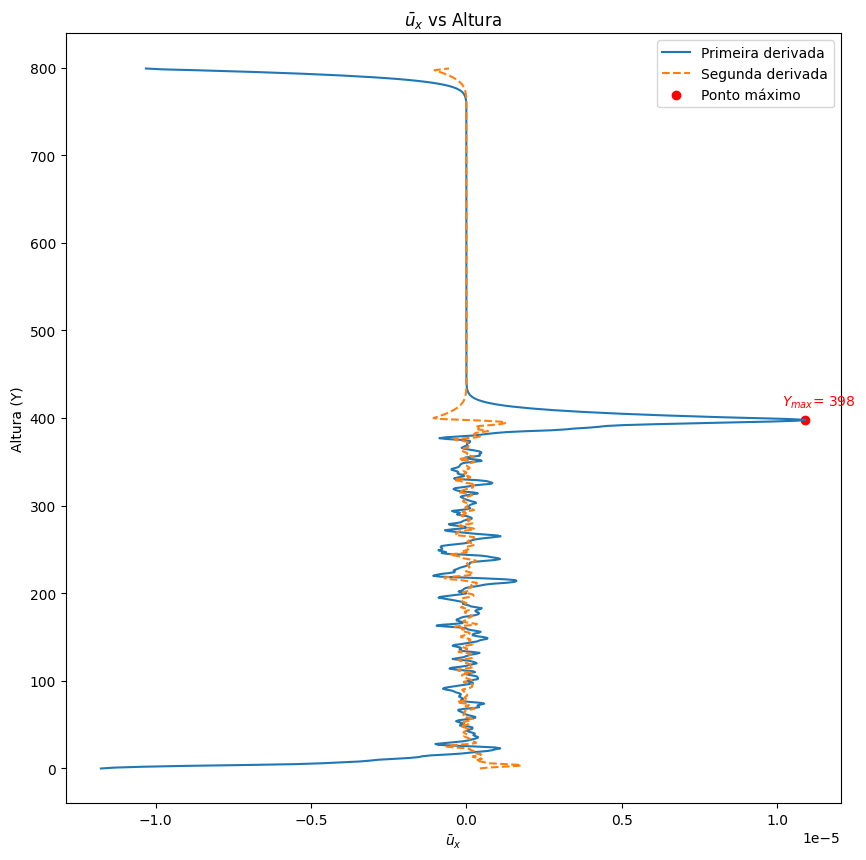

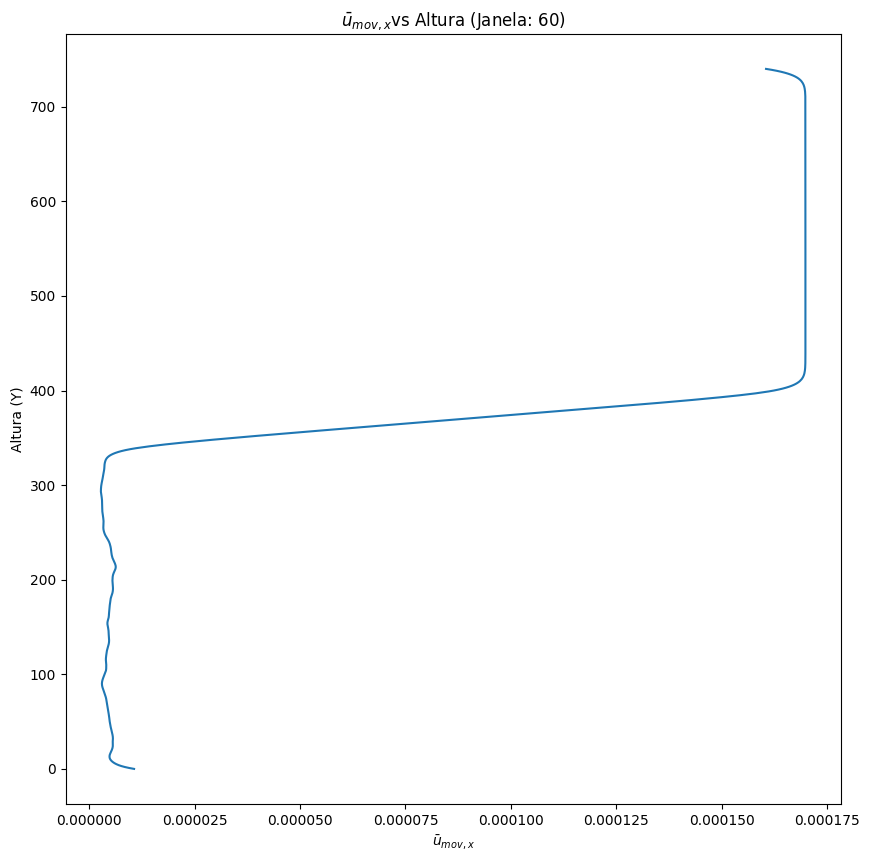

3.974669529899363e-10


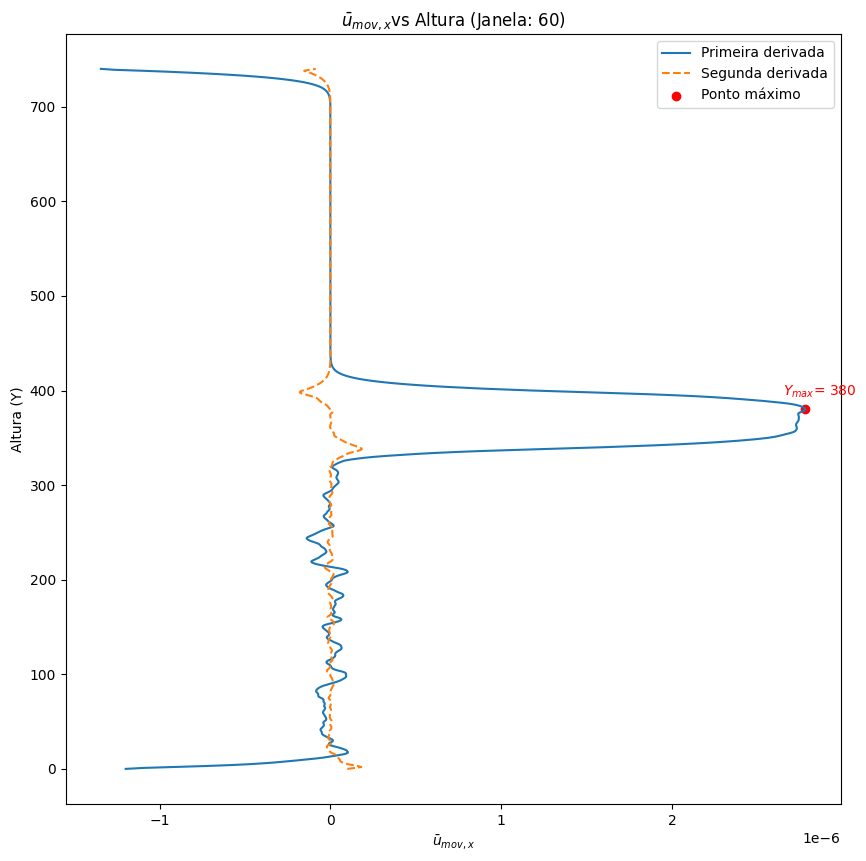

In [25]:
for i in range(5):
    for j in range(3):
        file_path = f'data{i + 1}_{j + 1}.hdf5'
        with h5py.File(file_path, 'r') as f:

            group = f["raw_data"]

            mask = np.array(f["mask_data"]['mask_data'])

            dataset_names = list(group.keys())

            dataset_names.sort()

            last_dataset_name = dataset_names[-1]

            raw_matrix = jnp.array(group[last_dataset_name])
            print(raw_matrix.shape)
            data = raw_matrix[:, :, :]
            print(data.shape)

            vel = get_macroscopic_velocities(data)
            figures = plot_mean_vel_x(vel)
            # plot_velocity_field(vel, mask[:,:], apply_sampling=True,scale=0.05, sampling_rate=10)
            # plot_velocity_field(vel, mask[:,:], x_range=(250, 350), y_range=(250, 400),scale=0.02, apply_sampling=False)

            for k, figure in enumerate(figures):
                figure.savefig(f'data/velocities_{i + 1}_{j + 1}_{k}', dpi=300, bbox_inches='tight')



